In [1]:
import sys

sys.path
sys.executable

'/Users/nandinisahu/opt/anaconda3/envs/py3/bin/python'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.Util import mask_util
from lenstronomy.Util.util import array2image
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Plots import  plot_util
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
import h5py
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
import corner
import pandas as pd
import math
from chainconsumer import Chain, ChainConsumer, ChainConfig, PlotConfig,Truth 


cwd = os.getcwd()
base_path = cwd
print('Base directory path:', base_path)

/Users/nandinisahu/opt/anaconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Base directory path: /Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/compound_lens/compound_lens_dcls1507-NS-main/notebooks


In [3]:
import lenstronomy
lenstronomy.__version__

'1.12.3'

In [4]:
import matplotlib as mpl

# for MNRAS
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import matplotlib.image as mpimg
import seaborn as sns
import coloripy as cp

# to change tex to Times New Roman in mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'


sns.set(style='ticks', context='paper', font='Times New Roman', font_scale=2.)
#sns.set_context('talk')
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "axes.linewidth": 2.0,})
#sns.set_palette('Set2')

cmap = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.6, dark=0.8, reverse=False, as_cmap=True)
cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.2, dark=1., reverse=False, as_cmap=True)

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale='power', power=2.5)

In [5]:
def import_data(filter_name):
    
    data_file = os.path.join('../data/image_DCLS1507+0522_{}.h5'.format(filter_name))
    f = h5py.File(data_file, 'r')
    
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
    f.close()

    # get data and PSF estimate from file
    psf_file = os.path.join('../PSF files/psf_model_{}.h5'.format(filter_name))
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
    # psf_error_map = f['psf_error_map'][()]
    f.close()


    kwargs_psf = {'psf_type': "PIXEL", 
                'kernel_point_source': kernel_point_source ,
                'kernel_point_source_init': kernel_point_source ,
                #    'psf_error_map': psf_error_map,
                }

    return kwargs_data, kwargs_psf

kwargs_data_F200LP, kwargs_psf_F200LP = import_data('F200LP')
kwargs_data_F140W, kwargs_psf_F140W = import_data('F140W')

kwargs_data_F140W['ra_shift'] = kwargs_data_F140W['ra_shift'] - kwargs_data_F200LP['ra_shift']
kwargs_data_F140W['dec_shift'] = kwargs_data_F140W['dec_shift'] - kwargs_data_F200LP['dec_shift']

kwargs_data_F200LP['ra_shift'] = 0
kwargs_data_F200LP['dec_shift'] = 0

In [6]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05)

#z_lens = 0.594
# Dominique and Lise claim 2.27 for the qso and 2.35 for the other blob.
#z_source_1 = 2.164
#z_source_2 = 2.6

z_l = 0.594
z_s1 = 2.163
z_s2 = 2.591

D_l=cosmo.angular_diameter_distance(z_l).value
D_s1 = cosmo.angular_diameter_distance(z_s1).value
D_s2 = cosmo.angular_diameter_distance(z_s2).value
D_ls1 = cosmo.angular_diameter_distance_z1z2(z_l, z_s1).value
D_ls2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s2).value

#cosmological scaling factor=deflection_scaling= 1/β
deflection_scaling = D_s1 / D_ls1 * D_ls2 / D_s2  
beta=1/deflection_scaling
print('Deflection angle rescale factor: {:.6f}'.format(deflection_scaling))
print('Beta:{:.6f}'.format(beta))

Deflection angle rescale factor: 1.060133
Beta:0.943278


In [7]:
 job_name_out = 'composite_F140W_5_2_Dist_Ratio_3_Beta_run01'
#job_name_out = job_name # use the local `job_name` to check the output of the local run

#local run
#input_temp = os.path.join(base_path, 'local_temp', job_name_out +'.txt')
#output_temp = os.path.join(base_path, 'local_temp', job_name_out +'_out.txt')

#cluster run
input_temp = os.path.join(base_path, 'midway_temp', job_name_out +'.txt')
output_temp = os.path.join(base_path, 'midway_temp', job_name_out +'_out.txt')


f = open(output_temp, 'rb')
[input_, output_] = joblib.load(f)
f.close()

fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

-0.7868293721264027 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7868293721264019


/Users/nandinisahu/git_src/lenstronomy/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/nandinisahu/git_src/lenstronomy/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/nandinisahu/git_src/lenstronomy/lenstronomy/Plots/model_band_plot.py:224: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


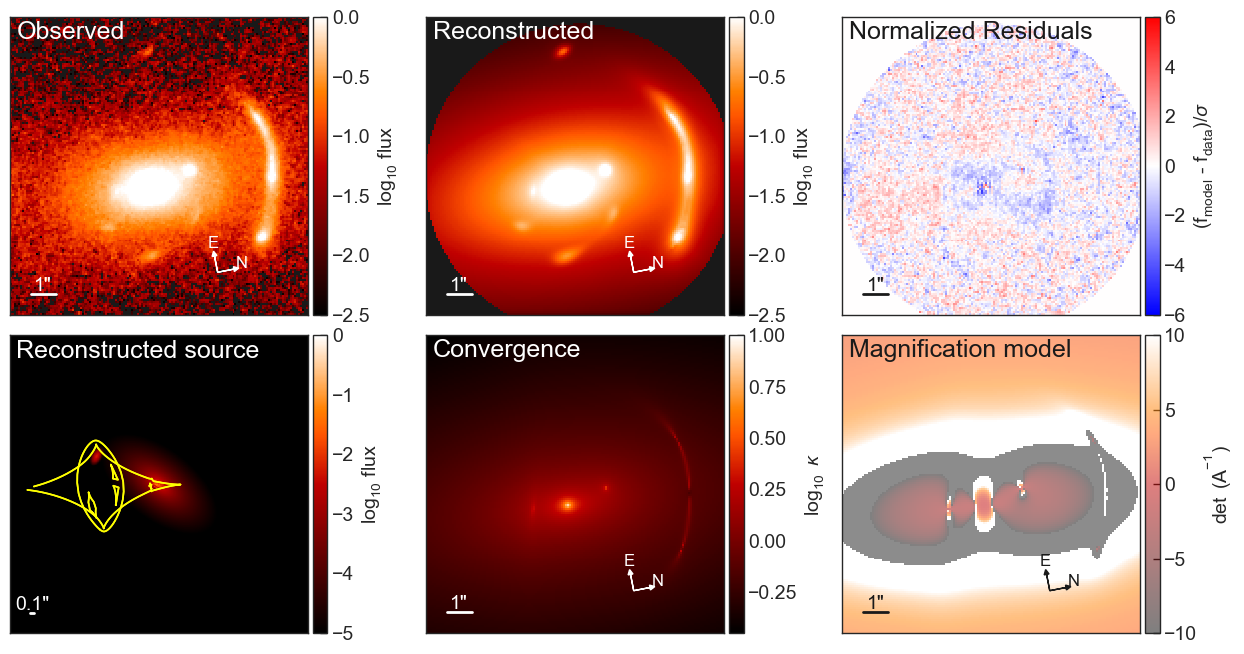

In [20]:
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.plot_util import coordinate_arrows, text_description

plt.rcParams.update({
    "font.family": "serif",    # Options: 'serif', 'sans-serif', 'monospace'
    "font.serif": ["Arial"],  # Specify the serif font Helvetica
    "font.size": 12,            # Adjust font size
    "axes.labelsize": 14,       # Label size
    "axes.titlesize": 16,       # Title size
    "xtick.labelsize": 12,      # X-axis tick labels
    "ytick.labelsize": 12,      # Y-axis tick labels
})

# Extract necessary values from multi_band_list_out
data_dict = multi_band_list_out[0][0]  # Extract the first dataset
ra_at_xy_0 = data_dict['ra_at_xy_0']
dec_at_xy_0 = data_dict['dec_at_xy_0']
transform_pix2angle = data_dict['transform_pix2angle']
# Create the coordinate transformation instance
coords = Coordinates( transform_pix2angle,ra_at_xy_0, dec_at_xy_0)

modelPlot1 = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, 
                      arrow_size=0.02, cmap_string="gist_heat", #inferno gist_heat #arrow_size=0.02
                      image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list']
                      )

# Create the plots
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)
#f.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)
f.subplots_adjust(wspace=0.02, hspace=0.07)

# Generate model plots no_arrow=True to switch off default arrow location
modelPlot1.data_plot(ax=axes[0,0], font_size=14, v_min=-2.5, v_max=0,no_arrow=True,text=None)
coordinate_arrows(ax=axes[0,0], d=10.0, coords=coords, color='w', font_size=12, arrow_size=0.02)
text_description(ax=axes[0,0], d=12, text="Observed", color="w", backgroundcolor="none", flipped=False, font_size=18)


modelPlot1.model_plot(ax=axes[0,1], font_size=14, v_min=-2.5, v_max=0,no_arrow=True,text=None)
coordinate_arrows(ax=axes[0,1], d=10.0, coords=coords, color='w', font_size=12, arrow_size=0.02) #backgroundcolor=None,
text_description(ax=axes[0,1], d=12, text="Reconstructed", color="w", backgroundcolor="none", flipped=False, font_size=18)

modelPlot1.normalized_residual_plot(ax=axes[0,2], font_size=14, v_min=-6, v_max=6,no_arrow=True,text=None)
#coordinate_arrows(ax=axes[0,2], d=10.0, coords=coords, color='k', font_size=12, arrow_size=0.04)
text_description(ax=axes[0,2], d=12, text="Normalized Residuals", color="k", backgroundcolor="none", flipped=False, font_size=18)

modelPlot1.source_plot(ax=axes[1,0], font_size=14, deltaPix_source=0.01,
                       numPix=720, with_caustics=True, v_max=0, v_min=-5,
                       no_arrow=True,text=None)
#coordinate_arrows(ax=axes[1,0], d=10.0, coords=coords, color='w', font_size=12, arrow_size=0.04)
text_description(ax=axes[1,0], d=7.2, text="Reconstructed source", color="w", backgroundcolor="none", flipped=False, font_size=18)

modelPlot1.convergence_plot(ax=axes[1,1], no_arrow=True, font_size=14, v_max=1,text=None) #,no_arrow=True
coordinate_arrows(ax=axes[1,1], d=10.0, coords=coords, color='w', font_size=12, arrow_size=0.02)
text_description(ax=axes[1,1], d=12, text="Convergence", color="w", backgroundcolor="none", flipped=False, font_size=18)

modelPlot1.magnification_plot(ax=axes[1,2], font_size=14,no_arrow=True,text=None)
coordinate_arrows(ax=axes[1,2], d=10.0, coords=coords, color='k', font_size=12, arrow_size=0.02)
text_description(ax=axes[1,2], d=12, text="Magnification model", color="k", backgroundcolor="none", flipped=False, font_size=18)

#f.tight_layout()

plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_model1.pdf', dpi=1200)


#plt.savefig(fname=job_name_out+'2.pdf')
plt.show()


In [47]:
data_dict['transform_pix2angle'][0]

array([-0.01526581,  0.07852984])

-0.7868293721264027 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7868293721264019


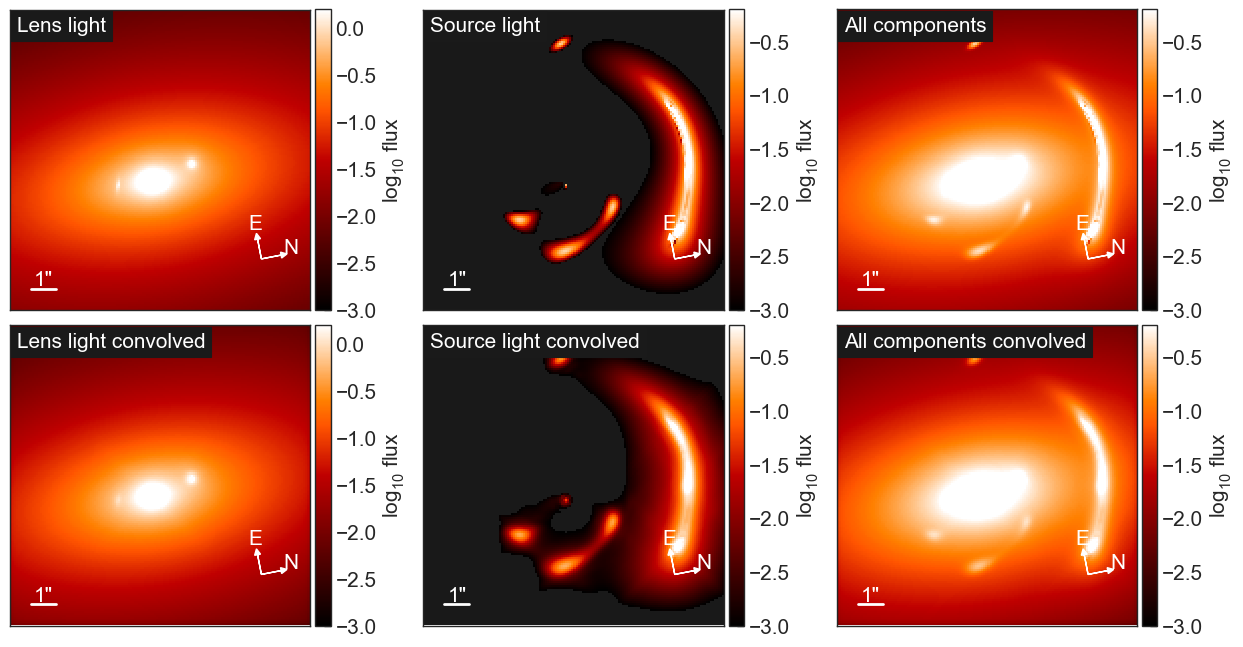

In [14]:
# band index to plot the model breakdown, 0: F140W, 1: F200LP
band_i = 0

lensPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, 
                     arrow_size=0.02, cmap_string="gist_heat",
                    image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'], #kwargs_likelihood['image_likelihood_mask_list'],
                    multi_band_type='multi-linear', linear_solver = True
                    )

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-3,v_max= 0.2) 
lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True, band_index=band_i, v_min=-3,v_max= 0.2) 

lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True, band_index=band_i, v_min=-3,v_max= -0.2) 
lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True, band_index=band_i, v_min=-3,v_max= -0.2) 

lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-3,v_max= -0.2) 
lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True, band_index=band_i, v_min=-3,v_max= -0.2) 
#f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

#lens_result, source_result, lens_light_result, ps_result = kwargs_result['kwargs_lens'], kwargs_result['kwargs_source'], kwargs_result['kwargs_lens_light'], kwargs_result['kwargs_ps']
#print('lens', lens_result, "\n\n source", source_result, '\n\n lens light', lens_light_result, '\n\n ps', ps_result)


In [12]:
Ell_dark_cmpnt=ellipticity2phi_q(kwargs_result['kwargs_lens'][0]["e1"], kwargs_result['kwargs_lens'][0]["e2"])
print("Dark component:",Ell_dark_cmpnt)
Ell_light_cmpnt=ellipticity2phi_q( -0.34236287347714034,  -0.02481065038820062)
print("Light component",Ell_light_cmpnt)

if (Ell_dark_cmpnt[1] >= (Ell_light_cmpnt[1] - 0.05)) and (abs(Ell_light_cmpnt[0] - 0.1 * Ell_light_cmpnt[0]) < abs(Ell_dark_cmpnt[0]) < abs(Ell_light_cmpnt[0] + 0.1 * Ell_light_cmpnt[0])):
    print("dark matter component has a similar orientation and axis ratio as light")
else:
    print("dark matter does not have a similar orientation and axis ratio as light ")

Dark component: (-1.504813710651554, 0.46504761986654924)
Light component (-1.5346251241748665, 0.48891425600472677)
dark matter component has a similar orientation and axis ratio as light


/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_9652/862859810.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 2000, N_walkers: 304, N_params: 38
Rs_lens0 29.5774 ± 2.5915
alpha_Rs_lens0 6.9166 ± 0.3591
e1_lens0 -0.3582 ± 0.0065
e2_lens0 -0.0476 ± 0.0026
gamma_ext_lens1 0.0983 ± 0.0077
psi_ext_lens1 1.4724 ± 0.0207
theta_E_lens2 0.1304 ± 0.0190
theta_E_lens3 0.0383 ± 0.0323
alpha_1_lens4 0.3910 ± 0.0471
theta_E_lens5 0.1031 ± 0.0117
R_sersic_source_light0 0.1858 ± 0.0097
n_sersic_source_light0 2.3407 ± 0.2631
e1_source_light0 0.0242 ± 0.0117
e2_source_light0 -0.3173 ± 0.0149
center_x_source_light0 -1.0722 ± 0.0074
center_y_source_light0 1.0544 ± 0.0343
beta_source_light1 0.0258 ± 0.0010
center_x_source_light1 -1.0837 ± 0.0070
center_y_source_light1 1.0071 ± 0.0335
R_sersic_source_light2 0.0568 ± 0.0023
n_sersic_source_light2 0.5496 ± 0.0898
e1_source_light2 0.0479 ± 0.0277
e2_source_light2 0.3152 ± 0.0291
center_x_source_light2 -0.1105 ± 0.0242
center_y_source_light2 -0.3221 ± 0.0270
center_x_lens_light0 -0.8000 ± 0.0008
center_y_lens_light0 -0.4814 ± 0.0010
R_sersic_lens_light1 0.3230 

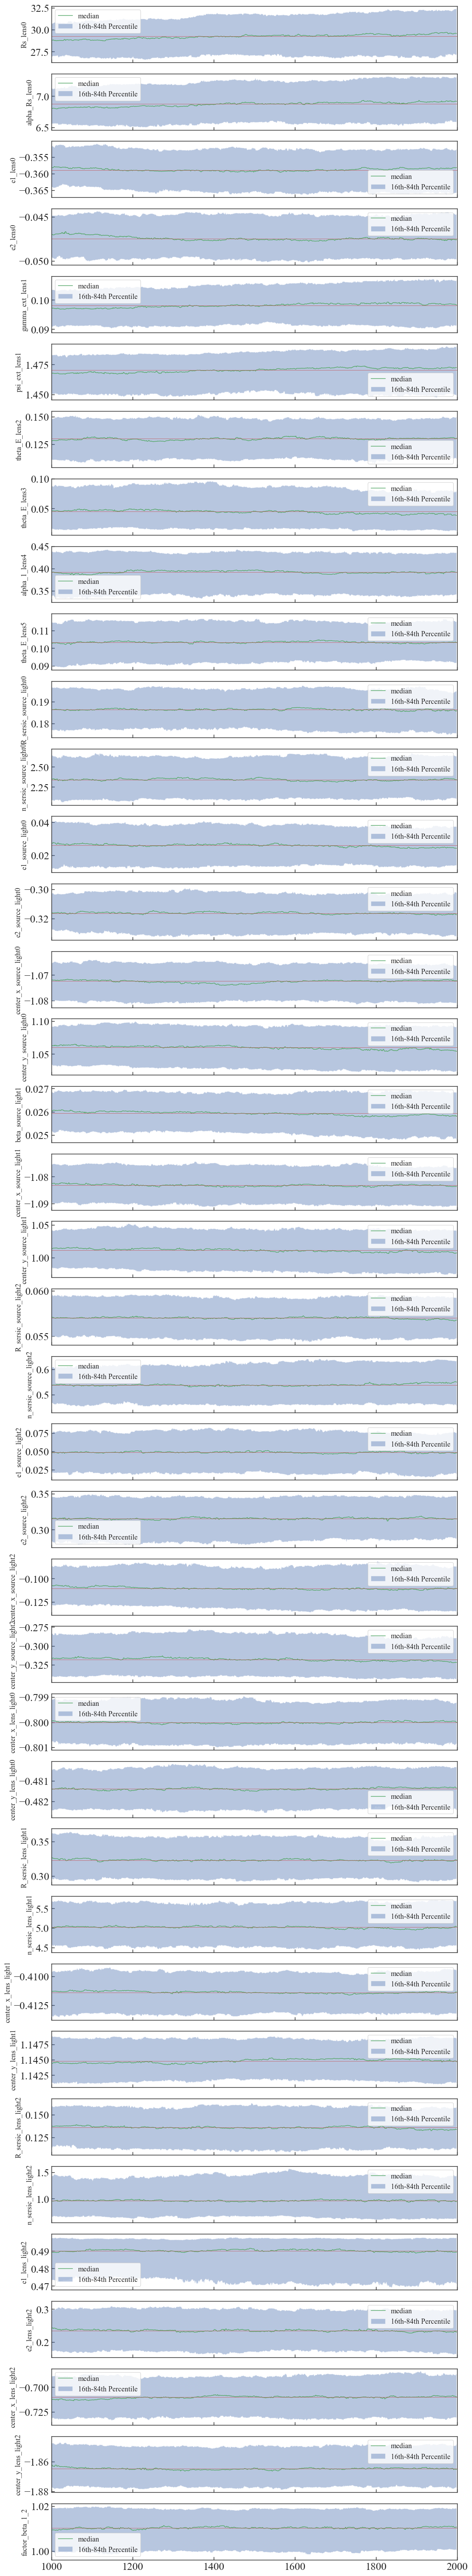

In [12]:
samples_mcmc = []

if fit_output[-1][0] != 'PSO':
    # if MCMC chain was broken in the chunks, we join the chunks to make the full chain
    mcmc_repeat = 1
      
    for k in range(len(fit_output)-mcmc_repeat, len(fit_output)):
        if samples_mcmc == []:
            samples_mcmc = fit_output[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, fit_output[k][1]))

        param_mcmc = fit_output[k][2]
    
if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 8 * n_params
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = 1000  #-1 #1000
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))

        ax[i].plot(median_pos[i][:last], c='g', label='median',lw=1)
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=0.5)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4,label='16th-84th Percentile')
        ax[i].set_ylabel(param_mcmc[i], fontsize=12)
        ax[i].set_xlim(1000, last)
        ax[i].legend(fontsize=12)
        
        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        plt.show()

In [13]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = fit_output[0]
    
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])


n, num_param = np.shape(samples_mcmc)
#plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)

number of non-linear parameters in the MCMC process:  38
parameters in order:  ['Rs_lens0', 'alpha_Rs_lens0', 'e1_lens0', 'e2_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'theta_E_lens2', 'theta_E_lens3', 'alpha_1_lens4', 'theta_E_lens5', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'center_x_source_light1', 'center_y_source_light1', 'R_sersic_source_light2', 'n_sersic_source_light2', 'e1_source_light2', 'e2_source_light2', 'center_x_source_light2', 'center_y_source_light2', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'n_sersic_lens_light1', 'center_x_lens_light1', 'center_y_lens_light1', 'R_sersic_lens_light2', 'n_sersic_lens_light2', 'e1_lens_light2', 'e2_lens_light2', 'center_x_lens_light2', 'center_y_lens_light2', 'factor_beta_1_2']
number of evaluations in the MCMC process:  608000


In [77]:
burnin_steps=1000*n_walkers

# Your MCMC sample
sub_sample_mcmc = samples_mcmc[burnin_steps:, :]  # Last part of the sample, excluding burn-in
col_name = param_mcmc[:]           # Parameter names

# Calculate the median for each parameter
medians_all_para = np.median(sub_sample_mcmc, axis=0)
q16_pos_all_para = np.percentile(sub_sample_mcmc, 16.,axis=0)
q84_pos_all_para = np.percentile(sub_sample_mcmc, 84.,axis=0)

bound68_sym_all_para=np.abs((q84_pos_all_para-q16_pos_all_para)/2)


print("Parameter values with actual assymetric credible regions (removed burnin) ")
for i in range(n_params):
    
    print(param_mcmc[i], '{:.3f} +{:.3f}  -{:.3f}'.format(medians_all_para[i], (q84_pos_all_para[i]-medians_all_para[i]), (medians_all_para[i]-q16_pos_all_para[i])))

print("\n \n Parameter values with symmetrized credible regions (removed burnin)")    
for i in range(n_params):
    print(param_mcmc[i], '{:.3f} +/-{:.3f}'.format(medians_all_para[i], bound68_sym_all_para[i]))

Parameter values with actual assymetric credible regions (removed burnin) 
Rs_lens0 29.209 +2.444  -2.293
alpha_Rs_lens0 6.864 +0.372  -0.315
e1_lens0 -0.359 +0.006  -0.007
e2_lens0 -0.047 +0.003  -0.002
gamma_ext_lens1 0.098 +0.007  -0.007
psi_ext_lens1 1.470 +0.015  -0.021
theta_E_lens2 0.130 +0.019  -0.019
theta_E_lens3 0.044 +0.042  -0.029
alpha_1_lens4 0.392 +0.045  -0.053
theta_E_lens5 0.103 +0.012  -0.012
R_sersic_source_light0 0.186 +0.010  -0.010
n_sersic_source_light0 2.341 +0.294  -0.247
e1_source_light0 0.026 +0.013  -0.013
e2_source_light0 -0.316 +0.014  -0.015
center_x_source_light0 -1.073 +0.007  -0.008
center_y_source_light0 1.060 +0.034  -0.033
beta_source_light1 0.026 +0.001  -0.001
center_x_source_light1 -1.083 +0.008  -0.007
center_y_source_light1 1.011 +0.033  -0.033
R_sersic_source_light2 0.057 +0.002  -0.002
n_sersic_source_light2 0.538 +0.087  -0.078
e1_source_light2 0.049 +0.029  -0.029
e2_source_light2 0.316 +0.030  -0.032
center_x_source_light2 -0.110 +0.025 

In [15]:
# Initialize dictionaries
median_dict = {}
plus_error_dict = {}
minus_error_dict = {}

# Iterate over parameters and populate dictionaries
for i in range(n_params):
    median_dict[param_mcmc[i]] = medians_all_para[i]
    plus_error_dict[param_mcmc[i]] = q84_pos_all_para[i] - medians_all_para[i]
    minus_error_dict[param_mcmc[i]] = medians_all_para[i] - q16_pos_all_para[i]

# Example output
print("Median dictionary:\n", median_dict)
print("\nPlus error dictionary:\n", plus_error_dict)
print("\nMinus error dictionary:\n", minus_error_dict)


Median dictionary:
 {'Rs_lens0': 29.20878462486606, 'alpha_Rs_lens0': 6.864115637824819, 'e1_lens0': -0.3588520458458878, 'e2_lens0': -0.04743816532841309, 'gamma_ext_lens1': 0.09801640687785074, 'psi_ext_lens1': 1.4702807689498285, 'theta_E_lens2': 0.1298669109056417, 'theta_E_lens3': 0.044264828603016726, 'alpha_1_lens4': 0.3916408724249584, 'theta_E_lens5': 0.1033299683939684, 'R_sersic_source_light0': 0.1863346228797269, 'n_sersic_source_light0': 2.3405306784591877, 'e1_source_light0': 0.025872605226805036, 'e2_source_light0': -0.31625191767454397, 'center_x_source_light0': -1.0725274404435694, 'center_y_source_light0': 1.0600326307140477, 'beta_source_light1': 0.025935359124261922, 'center_x_source_light1': -1.0832078027978493, 'center_y_source_light1': 1.0112943042502336, 'R_sersic_source_light2': 0.05699485376011259, 'n_sersic_source_light2': 0.5381741741470153, 'e1_source_light2': 0.04859022332098996, 'e2_source_light2': 0.31560472222219615, 'center_x_source_light2': -0.1104282

### main lens para corner plot

In [16]:
sub_sample_mcmc

array([[28.42158567,  6.723286  , -0.37025193, ..., -0.71833771,
        -1.87296534,  0.99663115],
       [29.11048931,  6.84178947, -0.36215226, ..., -0.68145183,
        -1.85957856,  1.01847638],
       [25.71038229,  6.34066083, -0.36575125, ..., -0.69456553,
        -1.83776052,  0.99341208],
       ...,
       [29.43043199,  6.79544099, -0.36288713, ..., -0.72247555,
        -1.88303063,  0.99871913],
       [30.92241398,  7.06130853, -0.36562035, ..., -0.74481283,
        -1.85280894,  0.99933779],
       [32.70786749,  7.26158715, -0.37397606, ..., -0.69856152,
        -1.84508431,  1.01718308]])

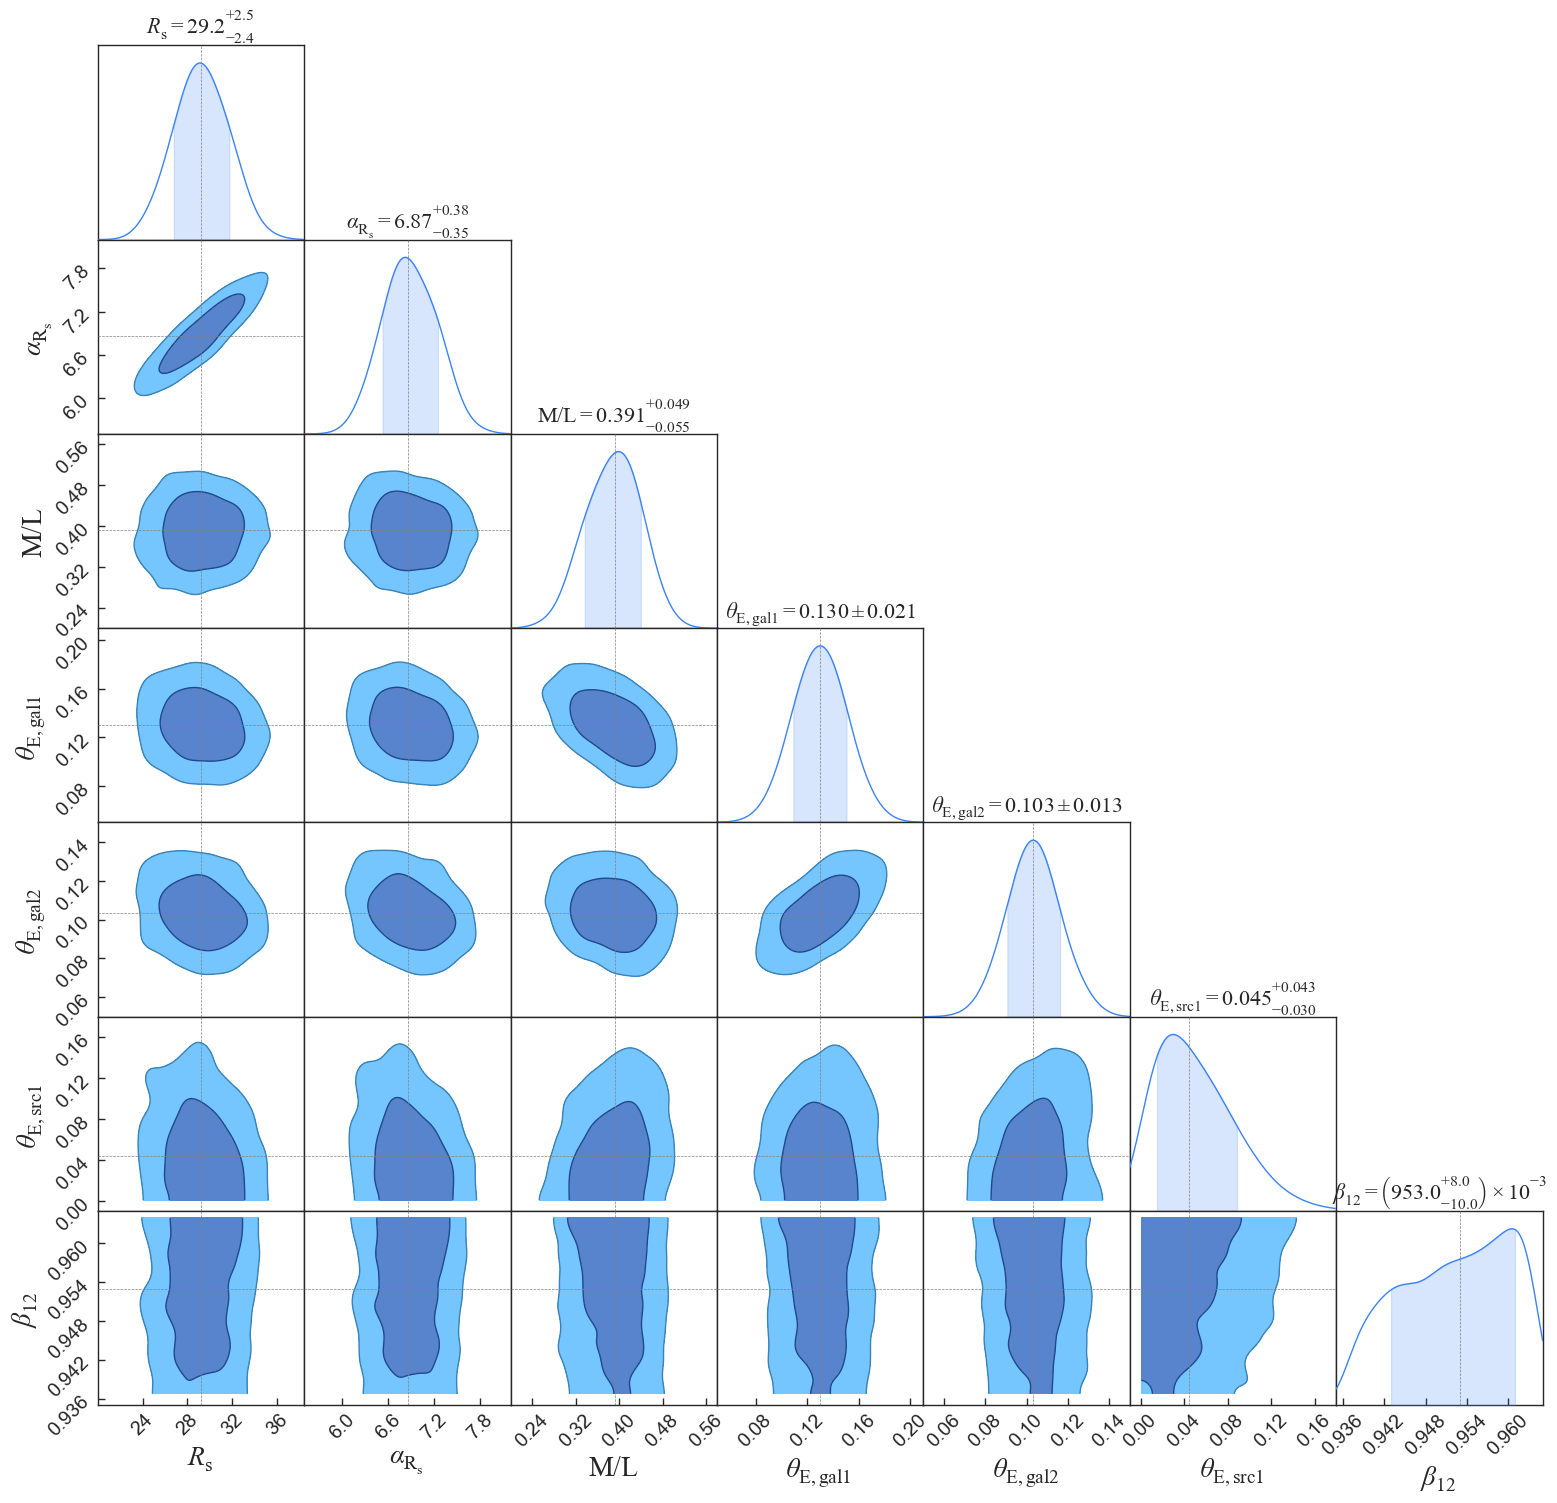

In [17]:
sample1 = np.hstack((sub_sample_mcmc[:, :2], sub_sample_mcmc[:, 8:9], sub_sample_mcmc[:, 6:7],
                     sub_sample_mcmc[:, 9:10], sub_sample_mcmc[:, 7:8],  beta*sub_sample_mcmc[:, -1:] ))
#col_name1 = param_mcmc[:2]+ param_mcmc[8:9]+ param_mcmc[6:7]+ param_mcmc[9:10] + param_mcmc[7:8] + param_mcmc[-1:] # Combine parameter names
medians1 = np.concatenate([medians_all_para[:2], medians_all_para[8:9], medians_all_para[6:7], medians_all_para[9:10], medians_all_para[7:8], beta*medians_all_para[-1:]])

col_name3 = [
    r"$R_{\mathrm{s}}$",
    r"$\alpha_{\mathrm{R_{s}}}$",
    r"$\mathrm{M/L}$",
    r"$\theta_{\mathrm{E,gal1}}$",
    r"$\theta_{\mathrm{E,gal2}}$",
    r"$\theta_{\mathrm{E,src1}}$",
    r"$\beta_{\mathrm{12}}$"
]
#print(sample1)


# Convert numpy array to pandas DataFrame
df1 = pd.DataFrame(sample1, columns=col_name3)

parameter_ranges = {
    df1.columns.tolist()[0]: (20, 38.4),
    df1.columns.tolist()[1]: (5.5, 8.2),
    df1.columns.tolist()[2]: (0.2, 0.58),
    df1.columns.tolist()[3]: (0.05, 0.21),
    df1.columns.tolist()[4]: (0.05, 0.15),
    df1.columns.tolist()[5]: (-0.01, 0.18),
    df1.columns.tolist()[6]: (0.935, 0.965)
}


# Create ChainConsumer object
c = ChainConsumer()

# Add your chain
c.add_chain(Chain(samples=df1,name="MCMC Chain",statistics="cumulative", smooth=10,bins=10,
                  shade_alpha=0.8
                ) ) #, name="MCMC Chain" kde=0.5,
#extents=parameter_ranges,truth=medians1,  location=medians1
#smooth=np.sqrt(sample1.shape[0]/1000)  

# Create the plot
c.set_plot_config(PlotConfig(extents=parameter_ranges,label_font_size=20,tick_font_size=14, summary_font_size=16,dpi=400))
#c.add_truth(Truth(medians1))
c.add_truth(Truth(location={df1.columns.tolist()[0]: medians1[0], 
                            df1.columns.tolist()[1]: medians1[1],
                            df1.columns.tolist()[2]: medians1[2],
                            df1.columns.tolist()[3]: medians1[3],
                            df1.columns.tolist()[4]: medians1[4],
                            df1.columns.tolist()[5]: medians1[5],
                            df1.columns.tolist()[6]: medians1[6]}, line_style="--", line_width=0.5,color="gray"))

fig = c.plotter.plot( )

# Customize the plot appearance
#plt.tight_layout()

# Save the plot if needed
plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_mcmc_cumulative.pdf') #, dpi=1200

### subsampling mcmc chain

In [18]:
sub_sample_mcmc_df = pd.DataFrame(sub_sample_mcmc, columns=col_name)
print(np.shape(sub_sample_mcmc_df))

# Assume sub_sample_mcmc_df is already defined
num_samples_original = sub_sample_mcmc_df.shape[0]
num_samples_target = 500  # Set the desired downsampled size

# Method 1: Random Subsampling (Recommended for well-mixed chains)
if num_samples_original > num_samples_target:
    sub_sample_mcmc_downsampled = sub_sample_mcmc_df.sample(n=num_samples_target, random_state=42)
else:
    sub_sample_mcmc_downsampled = sub_sample_mcmc_df.copy()  # No downsampling needed


# Method 2: Thinning (Every k-th sample, if autocorrelation is high)
#thinning_factor = num_samples_original // num_samples_target
#sub_sample_mcmc_thinned = sub_sample_mcmc_df.iloc[::thinning_factor] if num_samples_original > num_samples_target else sub_sample_mcmc_df


(304000, 38)


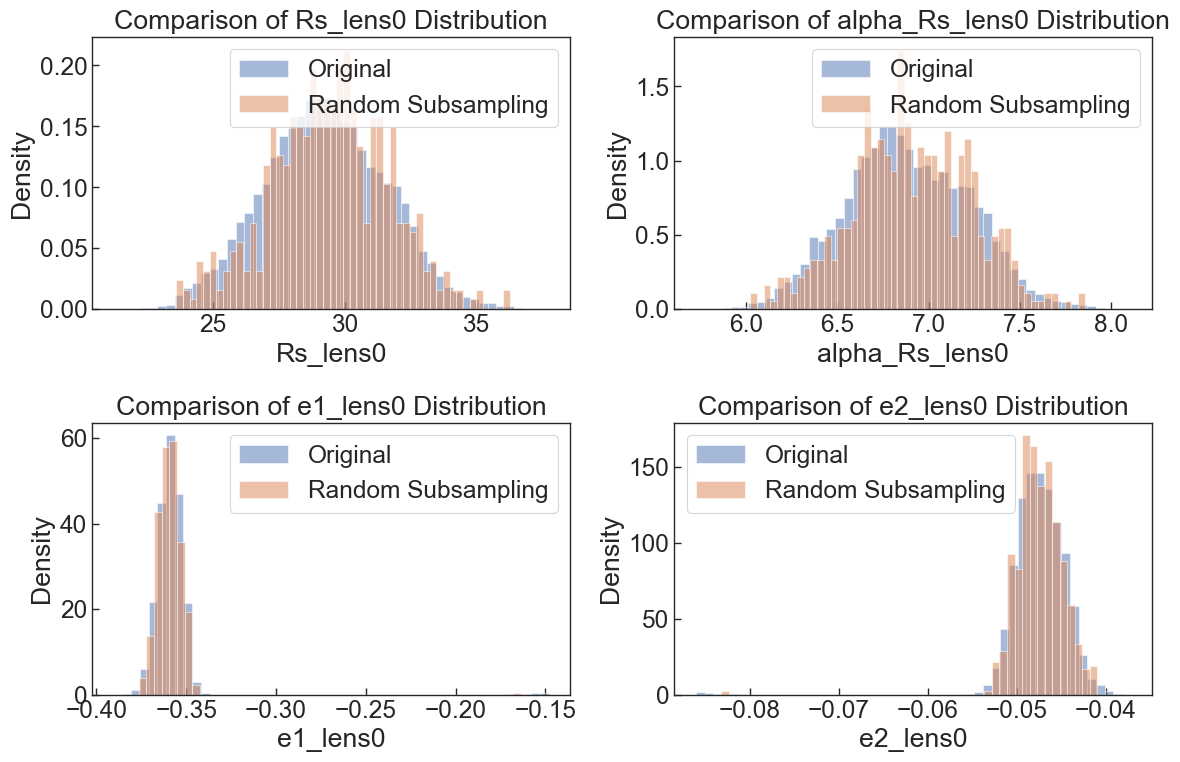

In [19]:
# Plot distributions before and after downsampling for key parameters
params_to_check = sub_sample_mcmc_df.columns[:4]  # index range for parameters to check

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, param in enumerate(params_to_check):
    ax = axes[i // 2, i % 2]
    ax.hist(sub_sample_mcmc_df[param], bins=50, alpha=0.5, label="Original", density=True)
    ax.hist(sub_sample_mcmc_downsampled[param], bins=50, alpha=0.5, label="Random Subsampling", density=True)
    #ax.hist(sub_sample_mcmc_thinned[param], bins=50, alpha=0.5, label="Thinning", density=True)
    ax.set_xlabel(param)
    ax.set_ylabel("Density")
    ax.legend()
    ax.set_title(f"Comparison of {param} Distribution")

plt.tight_layout()
plt.show()

# Return the best downsampled DataFrame
sub_sample_mcmc_final = sub_sample_mcmc_downsampled  # Choose based on performance

# Display the downsampled DataFrame
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Downsampled MCMC Chain", dataframe=sub_sample_mcmc_final)

## Flux and R_half estimation

### All Lenses only using best fit parameter

In [20]:
lens_light_model_list= [ 'DOUBLE_CHAMELEON','SERSIC','SERSIC_ELLIPSE']
lens_light_analysis=LightProfileAnalysis(LightModel(lens_light_model_list))
#lens_light_analysis_gal1=LightProfileAnalysis(LightModel([lens_light_model_list[1]]))

#effective diemnsion of aperture in each direction = grid_num*grid_spacing
print("The flux and R_half for the main lenses varies with grid_num. Grid number should be different depending on size of objects ")

Reins_rough=3 #arcsec
#in For the main lens DOUBLE_CHAMELEON case flux value changes significantly with using grid_num and grid_spacing based on image
## lens_light_analysis.flux_components() Computes the total flux in each component of the model.

grid_number=200 #200
grid_space=0.08

component_flux=lens_light_analysis.flux_components(kwargs_result['kwargs_lens_light'],
                                                   grid_num=grid_number, #76 #note odd number is not working
                                                   grid_spacing=grid_space)

aperture_size=grid_number*grid_space

print(" size of box used for flux (in arcsec):", aperture_size)


lens_flux=component_flux[0][:]
print("main lens flux:",lens_flux)
R_half_lens=component_flux[1][:]
print("main lens  R_half:",R_half_lens)

The flux and R_half for the main lenses varies with grid_num. Grid number should be different depending on size of objects 
 size of box used for flux (in arcsec): 16.0
main lens flux: [3022.350667135901, 77.06795722976314, 7.881508056749886]
main lens  R_half: [1.9362280725162517, 0.3602284786076748, 0.13508567947787806]


## Main Lens 

#### with uncertainties from Double Chameleon fit to Sersic

In [84]:
# Load and read the pickle file
def load_pso_results(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

Main_lens_light_data = load_pso_results('PSO_results_sersic_to_chameleon.pkl')
print("Loaded keys:", Main_lens_light_data.keys())

#for PSO chain
parameter_names=Main_lens_light_data['pso_output'][0][2]
parameter_value_list=Main_lens_light_data['pso_output'][0][1][1]
#para_mean=np.mean(parameter_value_list, axis=0)
#para_stdev=np.std(parameter_value_list, axis=0)
para_median=np.median(parameter_value_list, axis=0)
print(para_median)
para_16_credible=np.percentile(parameter_value_list, 16.,axis=0)
print(para_16_credible)
para_84_credible=np.percentile(parameter_value_list, 84.,axis=0)
print(para_84_credible)

parameter_fit_uncer_list=Main_lens_light_data['pso_output'][0][1][2]

Main_lens_light_para={}
print("lens light parameter median and 68% credible interval")
for i in range(len(parameter_names)):
    Main_lens_light_para['%s' % parameter_names[i]] = (
        round(para_median[i], 3), 
        round(para_84_credible[i] - para_median[i], 3), 
        round(para_median[i] - para_16_credible[i], 3)
    )
print(Main_lens_light_para)

Loaded keys: dict_keys(['pso_output', 'kwargs_result'])
[ 0.97597208  0.07984774  0.34133432 -0.03378614 -0.01392539  0.33713301
  2.96583473 -0.36110699 -0.01744849 -0.79900023 -0.47805098]
[ 0.95790954  0.07760142  0.33565862 -0.03624459 -0.01444166  0.32961697
  2.96302214 -0.36176562 -0.01772667 -0.7990871  -0.47816832]
[ 0.98578122  0.0810397   0.34793153 -0.03085566 -0.01350836  0.33983383
  2.97184954 -0.36043367 -0.01723002 -0.79895222 -0.4779399 ]
lens light parameter median and 68% credible interval
{'ratio_lens_light0': (0.976, 0.01, 0.018), 'w_c1_lens_light0': (0.08, 0.001, 0.002), 'w_t1_lens_light0': (0.341, 0.007, 0.006), 'e11_lens_light0': (-0.034, 0.003, 0.002), 'e21_lens_light0': (-0.014, 0.0, 0.001), 'w_c2_lens_light0': (0.337, 0.003, 0.008), 'w_t2_lens_light0': (2.966, 0.006, 0.003), 'e12_lens_light0': (-0.361, 0.001, 0.001), 'e22_lens_light0': (-0.017, 0.0, 0.0), 'center_x_lens_light0': (-0.799, 0.0, 0.0), 'center_y_lens_light0': (-0.478, 0.0, 0.0)}


{'ratio_lens_light0': (0.976, 0.01, 0.018), 'w_c1_lens_light0': (0.08, 0.001, 0.002), 'w_t1_lens_light0': (0.341, 0.007, 0.006), 'e11_lens_light0': (-0.034, 0.003, 0.002), 'e21_lens_light0': (-0.014, 0.0, 0.001), 'w_c2_lens_light0': (0.337, 0.003, 0.008), 'w_t2_lens_light0': (2.966, 0.006, 0.003), 'e12_lens_light0': (-0.361, 0.001, 0.001), 'e22_lens_light0': (-0.017, 0.0, 0.0), 'center_x_lens_light0': (-0.799, 0.0, 0.0), 'center_y_lens_light0': (-0.478, 0.0, 0.0)}


In [80]:
parameter_value_list

[[0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.47757532752788856],
 [0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.47757532752788856],
 [0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.47757532752788856],
 [0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.4775

In [23]:
main_lens_light_list= ['DOUBLE_CHAMELEON']
main_lens_light_analysis=LightProfileAnalysis(LightModel(main_lens_light_list))

fixed_amp = 317.9143590011411  # Fixed amplitude
main_lens_flux_list = []  # Store results
main_lens_R_half_list=[]
grid_number=400 #200
grid_space=0.04 #0.08

downsampled_parameter_value_list = parameter_value_list[::2]
#print(np.size(downsampled_parameter_value_list)) #this give the total number of elements (counting each parameters)
#print(downsampled_parameter_value_list)

i=0
for params in parameter_value_list:
    light_para = [{
        'amp': fixed_amp,
        'ratio': params[0],
        'w_c1': params[1],
        'w_t1': params[2],
        'e11': params[3],
        'e21': params[4],
        'w_c2': params[5],
        'w_t2': params[6],
        'e12': params[7],
        'e22': params[8],
        'center_x': params[9],
        'center_y': params[10],
    }]
    
    individual_flux_rhalf = main_lens_light_analysis.flux_components(
        light_para,
        grid_num=grid_number,
        grid_spacing=grid_space
    )
    
    main_lens_flux_list.append(individual_flux_rhalf[0])  # Store result
    main_lens_R_half_list.append(individual_flux_rhalf[1])
    i=i+1


In [24]:
print("number of parameters sets averaged over",i)

main_lens_flux_count=np.mean(main_lens_flux_list)
uncer_main_lens_flux_count=np.std(main_lens_flux_list)
print("mean_flux", main_lens_flux_count, uncer_main_lens_flux_count)

main_lens_R_half=np.mean(main_lens_R_half_list)
uncer_main_lens_R_half=np.std(main_lens_R_half_list)
print("mean_R_half",main_lens_R_half,uncer_main_lens_R_half)

number of parameters sets averaged over 100
mean_flux 3018.425623283982 1.900376470038151
mean_R_half 1.9410929671708153 0.0


### Main lens  ( from double sersic best fit)

#### From file "DCLS1507_from_scratch_F140W_Source1_4_run01"

#### using best fit

In [25]:
lens_light_model_list_sersic=['SERSIC_ELLIPSE','SERSIC_ELLIPSE']
#R_sersic is cicularlized unless if  sersic_major_axis=True used when modeling


sersic_lens_light_analysis_main_lens=LightProfileAnalysis(LightModel(lens_light_model_list_sersic))


sers_main_lens_light=[{'amp': 23.4215295088398, 
                  'R_sersic': 2.6660825376620307,'n_sersic': 2.1093844144711063, 
                  'e1': -0.34236287347714034, 'e2': -0.02481065038820062, 
                  'center_x': -0.8022522397048335, 'center_y': -0.485920077450554}, 
                 {'amp': 388.55507256414353, 
                  'R_sersic': 0.2936873590416222, 'n_sersic': 1.6435758136274998, 
                  'e1': 0.01908035124181226, 'e2': -0.014438394531870541, 
                  'center_x': -0.8022522397048335, 'center_y': -0.485920077450554}]


## chose grid_num such that R_h matches with the R_sersic for each component
main_lens_ser_flux=sersic_lens_light_analysis_main_lens.flux_components(sers_main_lens_light, grid_num=200,grid_spacing=0.08)
print(main_lens_ser_flux)
#flux value when using two sersics changes with grid_num and grid_spacing

main_lens_double_Sersic_flux =main_lens_ser_flux[0][0] +main_lens_ser_flux[0][1]
print("double_Sersic_flux_main_lens",main_lens_double_Sersic_flux)

sers_R_half_combined=sersic_lens_light_analysis_main_lens.half_light_radius(sers_main_lens_light,
                                                            grid_spacing=0.08, 
                                                            grid_num=200, #324
                                                           center_x=-0.8022522397048335,
                                                           center_y= -0.485920077450554)
print("R_half_combined",sers_R_half_combined)

([2412.157419923548, 496.1515202391182], [2.363999390862866, 0.2926856388687358])
double_Sersic_flux_main_lens 2908.308940162666
R_half_combined 1.8236566729513537


#### using mean parameters with uncertainty from chain

In [26]:
 main_lens_Sersic_job_name_out = 'DCLS1507_from_scratch_F140W_Source1_4_run01'

#cluster run
input_temp = os.path.join(base_path, 'midway_temp', main_lens_Sersic_job_name_out +'.txt')
output_temp = os.path.join(base_path, 'midway_temp', main_lens_Sersic_job_name_out +'_out.txt')


f = open(output_temp, 'rb')
[input1_, output1_] = joblib.load(f)
f.close()

fitting_kwargs_list1, multi_band_list1,  kwargs_model1,  kwargs_constraints1,  kwargs_likelihood1,  kwargs_params1,  init_samples1 = input1_

kwargs_result1, multi_band_list_out1, fit_output1, _ = output1_

In [27]:
#np.shape(fit_output1) =(2, 3) 
#there are two PSO chains values for the two chains are in: fit_output1[0][1][1], fit_output1[1][1][1]
#first chain obviously is quite far from the final values.
# So, for the final flux count credible region, I am using the second chain

sersic_case_para_names=fit_output1[1][2]
fit_output1_joined=fit_output1[1][1][1]

# Parameters to extract
main_lens_sersic_params_to_extract = [
'R_sersic_lens_light0',
 'n_sersic_lens_light0',
 'e1_lens_light0',
 'e2_lens_light0',
 'center_x_lens_light0',
 'center_y_lens_light0',
 'R_sersic_lens_light1',
 'n_sersic_lens_light1',
 'e1_lens_light1',
 'e2_lens_light1'
]

# Get indices of required parameters
indices_sersic_para = [sersic_case_para_names.index(param) for param in main_lens_sersic_params_to_extract]

# Extract the selected values for each parameter set
extracted_main_lens_sersic = [[param_set[i] for i in indices_sersic_para] for param_set in fit_output1_joined]

# Output
print(np.shape(extracted_main_lens_sersic))

(500, 10)


In [28]:
Sersic1_fixed_amp = 23.4215295088398 # Fixed amplitude
Sersic2_fixed_amp = 388.55507256414353  # Fixed amplitude
main_lens_2sersic_flux_list = []  # Store results
main_lens_2sersic_R_half_list=[]
grid_number_ser=400
grid_space_ser=0.04

downsampled_extracted_main_lens_sersic = extracted_main_lens_sersic[::5]
#print(np.size(downsampled_parameter_value_list)) #this give the total number of elements (counting each parameters)
#print(downsampled_parameter_value_list)

j=0 
for params in downsampled_extracted_main_lens_sersic:
    sersic_light_para = [
        {'amp': Sersic1_fixed_amp, 
        'R_sersic': params[0],'n_sersic': params[1], 
        'e1': params[2], 'e2': params[3], 
        'center_x': params[4], 'center_y': params[5]}, 
        {'amp': Sersic2_fixed_amp, 
        'R_sersic': params[6], 'n_sersic': params[7], 
        'e1': params[8], 'e2': params[9], 
        'center_x': params[4], 'center_y':params[5]}
        
    ]
    
    individual_flux_rhalf = sersic_lens_light_analysis_main_lens.flux_components(
        sersic_light_para,
        grid_num=grid_number_ser,
        grid_spacing=grid_space_ser
    )
    
    Sersic_flux_combined=individual_flux_rhalf[0][0]+individual_flux_rhalf[0][1]
    
    individual_R_half_combined=sersic_lens_light_analysis_main_lens.half_light_radius(sersic_light_para,
                                                            grid_spacing=grid_space_ser, 
                                                            grid_num=grid_number_ser, #324
                                                           center_x=params[4],
                                                           center_y= params[5])

    main_lens_2sersic_flux_list.append(Sersic_flux_combined)  # Store result
    main_lens_2sersic_R_half_list.append(individual_R_half_combined)
    j=j+1


In [29]:
print("number of parameters sets averaged over",j)

main_lens_double_sersic_flux_count=np.mean(main_lens_2sersic_flux_list)
uncer_main_lens_double_sersic_flux_count=np.std(main_lens_2sersic_flux_list)
print("mean_flux", main_lens_double_sersic_flux_count, uncer_main_lens_double_sersic_flux_count)

main_lens_ds_flux_median=np.median(main_lens_2sersic_flux_list)
main_lens_ds_flux_conf_low,main_lens_ds_flux_conf_high=np.percentile(main_lens_2sersic_flux_list, [16, 84])
print("median_flux",main_lens_ds_flux_median, (main_lens_ds_flux_median-main_lens_ds_flux_conf_low),(main_lens_ds_flux_median-main_lens_ds_flux_conf_high))

main_lens_double_sersic_R_half=np.mean(main_lens_2sersic_R_half_list)
uncer_main_lens_double_sersic_R_half=np.std(main_lens_2sersic_R_half_list)
print("mean_R_half",main_lens_double_sersic_R_half,uncer_main_lens_double_sersic_R_half)

number of parameters sets averaged over 100
mean_flux 2916.208152749392 4.43374995463036
median_flux 2914.757164133383 2.885311451403595 -8.42397577147176
mean_R_half 1.8149219243047128 0.01110109499463908


### galaxy1

#### using best fit

In [30]:
lens_light_analysis_gal1=LightProfileAnalysis(LightModel([lens_light_model_list[1]]))

print("Gal1 lens light para:",kwargs_result['kwargs_lens_light'][1])
#grid_num is decided by matching with R_sersic parameter
R_half_gal1=lens_light_analysis_gal1.half_light_radius([kwargs_result['kwargs_lens_light'][1]],
                                                            grid_spacing=0.05, 
                                                            grid_num=200, # 70 only even number working here
                                                           center_x=kwargs_result['kwargs_lens_light'][1]['center_x'],
                                                           center_y= kwargs_result['kwargs_lens_light'][1]['center_y'])

print("\n Gal1 R_half separate calc:",R_half_gal1)

flux_gal1=lens_light_analysis_gal1.flux_components([kwargs_result['kwargs_lens_light'][1]], grid_num=200,grid_spacing=0.05)

print("\n Gal1 Flux and R_half:",flux_gal1)

Gal1 lens light para: {'amp': 38.465944293040366, 'R_sersic': 0.29495356677141515, 'n_sersic': 4.835007497137619, 'center_x': -0.41190306164198515, 'center_y': 1.1449900656274565}

 Gal1 R_half separate calc: 0.30957134880347054

 Gal1 Flux and R_half: ([78.38309767206667], [0.30957134880347054])


#### using chain

In [31]:
Gal1_light_para=[
'R_sersic_lens_light1',
 'n_sersic_lens_light1',
 'center_x_lens_light1',
 'center_y_lens_light1']

# Find indices of these parameters in col_name
indices_Gal1_light_params = [col_name.index(param) for param in Gal1_light_para if param in col_name]
print(indices_Gal1_light_params)

# Extract only the columns that match Gal1_light_para
Gal1_light_filtered_df = sub_sample_mcmc_downsampled[list(Gal1_light_para)]
Gal1_light_subset_df=Gal1_light_filtered_df.reset_index(drop=True)

Gal1_sersic_flux_list = []  # Store results
Gal1_r_half_list = [] 

Gal1_amp_value = 38.465944293040366 # from best fit

j=0 
for i in range(len(Gal1_light_subset_df)):
    gal1_light_para = [
        {'amp': Gal1_amp_value, 
        'R_sersic': Gal1_light_subset_df['R_sersic_lens_light1'][i],
        'n_sersic': Gal1_light_subset_df['n_sersic_lens_light1'][i], 
        'center_x': Gal1_light_subset_df['center_x_lens_light1'][i], 
        'center_y': Gal1_light_subset_df['center_y_lens_light1'][i]} 
    ]
    
    individual_flux_rhalf=lens_light_analysis_gal1.flux_components(gal1_light_para, 
                                                       grid_num=200, #matched to obtained model Rsersic
                                                       grid_spacing=0.05)


    Gal1_sersic_flux_list.append(individual_flux_rhalf[0])  # Store result
    Gal1_r_half_list.append(individual_flux_rhalf[1])
    j=j+1


print("number of parameters sets averaged over",j)

#Gal1_flux_count=np.mean(Gal1_sersic_flux_list)
#uncer_Gal1_flux_count=np.std(Gal1_sersic_flux_list)

Gal1_flux_count=np.median(Gal1_sersic_flux_list)
plus_Gal1_flux_count=np.percentile(Gal1_sersic_flux_list, 84)-Gal1_flux_count
minus_Gal1_flux_count=Gal1_flux_count-np.percentile(Gal1_sersic_flux_list, 16)

print(f"median_flux: {Gal1_flux_count:.2f}^{{+{plus_Gal1_flux_count:.2f}}}_{{-{minus_Gal1_flux_count:.2f}}}")

Gal1_R_half=np.median(Gal1_r_half_list)
plus_Gal1_R_half=np.percentile(Gal1_r_half_list,84)-Gal1_R_half
minus_Gal1_R_half=Gal1_R_half-np.percentile(Gal1_r_half_list,16)

print(f"median_R_half: {Gal1_R_half:.2f}^{{+{plus_Gal1_R_half:.2f}}}_{{-{minus_Gal1_R_half:.2f}}}")

[27, 28, 29, 30]
number of parameters sets averaged over 500
median_flux: 95.09^{+23.87}_{-18.79}
median_R_half: 0.34^{+0.03}_{-0.03}


### galaxy 2

#### with best fit

In [32]:
print("Gal2 lens light para:",kwargs_result['kwargs_lens_light'][2])

lens_light_analysis_gal2=LightProfileAnalysis(LightModel([lens_light_model_list[2]]))

# changing grid_num and grid_spacing is changing Rhalf but not the flux

R_half_gal2=lens_light_analysis_gal2.half_light_radius([kwargs_result['kwargs_lens_light'][2]],
                                                            grid_spacing=0.06, 
                                                            grid_num=60, #only even number working here
                                                           center_x=kwargs_result['kwargs_lens_light'][2]['center_x'],
                                                           center_y= kwargs_result['kwargs_lens_light'][2]['center_y'])

print("\n Gal2 R_half separate calc:",R_half_gal2)

flux_gal2=lens_light_analysis_gal2.flux_components([kwargs_result['kwargs_lens_light'][2]], grid_num=60,grid_spacing=0.06)

print("\n Gal2 Flux and R_half:",flux_gal2)

Gal2 lens light para: {'amp': 81.72226390220669, 'R_sersic': 0.0859204028717058, 'n_sersic': 1.65412970485776, 'e1': 0.49417143011170006, 'e2': 0.29529795622917443, 'center_x': -0.6955521763168532, 'center_y': -1.8725459277942826}

 Gal2 R_half separate calc: 0.09512000420521438

 Gal2 Flux and R_half: ([8.343513104701923], [0.09512000420521438])


#### using chain

In [33]:
Gal2_light_para=[
'R_sersic_lens_light2',
 'n_sersic_lens_light2',
 'e1_lens_light2',
 'e2_lens_light2',
 'center_x_lens_light2',
 'center_y_lens_light2'
]

# Find indices of these parameters in col_name
indices_Gal2_light_params = [col_name.index(param) for param in Gal2_light_para if param in col_name]
print(indices_Gal2_light_params)

# Extract only the columns that match Gal1_light_para
Gal2_light_filtered_df = sub_sample_mcmc_downsampled[list(Gal2_light_para)]
Gal2_light_subset_df=Gal2_light_filtered_df.reset_index(drop=True)

Gal2_sersic_flux_list = []  # Store results
Gal2_r_half_list = [] 

Gal2_amp_value = 81.72226390220669 # from best fit

j=0 
for i in range(len(Gal2_light_subset_df)):
    gal2_light_para = [
        {'amp': Gal2_amp_value, 
        'R_sersic': Gal2_light_subset_df['R_sersic_lens_light2'][i],
        'n_sersic': Gal2_light_subset_df['n_sersic_lens_light2'][i], 
        'e1': Gal2_light_subset_df['e1_lens_light2'][i], 
        'e2': Gal2_light_subset_df['e2_lens_light2'][i],
        'center_x': Gal2_light_subset_df['center_x_lens_light2'][i], 
        'center_y': Gal2_light_subset_df['center_y_lens_light2'][i]
        } 
    ]
    
    individual_flux_rhalf=lens_light_analysis_gal2.flux_components(gal2_light_para, 
                                                       grid_num=100,
                                                       grid_spacing=0.05)


    Gal2_sersic_flux_list.append(individual_flux_rhalf[0])  # Store result
    Gal2_r_half_list.append(individual_flux_rhalf[1])
    j=j+1


print("number of parameters sets averaged over",j)

#Gal1_flux_count=np.mean(Gal1_sersic_flux_list)
#uncer_Gal1_flux_count=np.std(Gal1_sersic_flux_list)

Gal2_flux_count=np.median(Gal2_sersic_flux_list)
plus_Gal2_flux_count=np.percentile(Gal2_sersic_flux_list, 84)-Gal2_flux_count
minus_Gal2_flux_count=Gal2_flux_count-np.percentile(Gal2_sersic_flux_list, 16)

print(f"median_flux: {Gal2_flux_count:.2f}^{{+{plus_Gal2_flux_count:.2f}}}_{{-{minus_Gal2_flux_count:.2f}}}")

Gal2_R_half=np.median(Gal2_r_half_list)
plus_Gal2_R_half=np.percentile(Gal2_r_half_list,84)-Gal2_R_half
minus_Gal2_R_half=Gal2_R_half-np.percentile(Gal2_r_half_list,16)

print(f"median_R_half: {Gal2_R_half:.2f}^{{+{plus_Gal2_R_half:.2f}}}_{{-{minus_Gal2_R_half:.2f}}}")

[31, 32, 33, 34, 35, 36]
number of parameters sets averaged over 500
median_flux: 16.97^{+7.45}_{-5.32}
median_R_half: 0.18^{+0.01}_{-0.05}


### Sources

In [34]:
source_model_list= ['SERSIC_ELLIPSE', 'SHAPELETS','SERSIC_ELLIPSE']
print("kwargs source:",kwargs_result['kwargs_source'])

source_light_analysis=LightProfileAnalysis(LightModel(source_model_list))
source_flux=source_light_analysis.flux_components(kwargs_result['kwargs_source'],
                                                 grid_num=60,
                                                grid_spacing=0.04)
#print("flux and half-light radius",source_flux)
src_flux=source_flux[0][:]
print("\n\nflux:",src_flux)
R_half_src=source_flux[1][:]
print("R_half:",R_half_src)

kwargs source: [{'amp': 17.471553851594653, 'R_sersic': 0.1813292038962566, 'n_sersic': 2.6162568623651543, 'e1': 0.04064538825330239, 'e2': -0.31742713881974927, 'center_x': -1.0765643884686877, 'center_y': 1.0442300306150405}, {'amp': array([ 381.22559477,  -96.72979199, -318.92751795,  -63.6451319 ,
       -331.35947807, -128.71055162, -146.36281991,  -47.25848799,
        -47.67277841, -228.48138585,  -52.86098858,   -8.71603125,
        103.39826559, -141.23670234, -128.95966533,   30.45147321,
        -25.75105366,  -18.06468546,  -30.96756389,  -57.92337795,
        -62.75498159,  -29.91780797,   10.00504858,  -13.67233702,
          6.39863313,   64.91597516,   40.59918464,   52.3503876 ,
         -2.37362974,  -44.64812815,  -19.85579583,    1.72758388,
         25.95388847,  -17.09941231,   63.18225979,  -80.42123496,
        -55.34234819,  -35.97376776,   -1.38978022,  -42.65529406,
        -11.14565635,  -88.21239469,   44.61432158,  -21.66592262,
        -68.10966312]), 'n

### Source 1

In [35]:
source1_model_list= ['SERSIC_ELLIPSE', 'SHAPELETS']

source1_light_analysis=LightProfileAnalysis(LightModel(source1_model_list))

#Amplitudes from #from best fit
amp_Src1_Sersic=17.471553851594653 
amp_Src1_Shapelet= np.array([ 381.22559477,  -96.72979199, -318.92751795,  -63.6451319 ,
         -331.35947807, -128.71055162, -146.36281991,  -47.25848799,
          -47.67277841, -228.48138585,  -52.86098858,   -8.71603125,
          103.39826559, -141.23670234, -128.95966533,   30.45147321,
          -25.75105366,  -18.06468546,  -30.96756389,  -57.92337795,
          -62.75498159,  -29.91780797,   10.00504858,  -13.67233702,
            6.39863313,   64.91597516,   40.59918464,   52.3503876 ,
           -2.37362974,  -44.64812815,  -19.85579583,    1.72758388,
           25.95388847,  -17.09941231,   63.18225979,  -80.42123496,
          -55.34234819,  -35.97376776,   -1.38978022,  -42.65529406,
          -11.14565635,  -88.21239469,   44.61432158,  -21.66592262,
          -68.10966312])

Src1_Shapelet_n_max=8

Src1_light_para=[
'R_sersic_source_light0',
 'n_sersic_source_light0',
 'e1_source_light0',
 'e2_source_light0',
 'center_x_source_light0',
 'center_y_source_light0',
 'beta_source_light1',
 'center_x_source_light1',
 'center_y_source_light1'
]

# Find indices of these parameters in col_name
indices_Src1_light_params = [col_name.index(param) for param in Src1_light_para if param in col_name]
print(indices_Src1_light_params)

# Extract only the columns that match Src1_light_para
Src1_light_filtered_df = sub_sample_mcmc_downsampled[list(Src1_light_para)]
Src1_light_subset_df=Src1_light_filtered_df.reset_index(drop=True) #resetting index

Src1_total_flux_list = []  # Store results
Src1_r_half_list = [] 

j=0 
for i in range(len(Src1_light_subset_df)):
    src1_light_para = [
        {'amp': amp_Src1_Sersic, 
        'R_sersic': Src1_light_subset_df['R_sersic_source_light0'][i],
        'n_sersic': Src1_light_subset_df['n_sersic_source_light0'][i], 
        'e1': Src1_light_subset_df['e1_source_light0'][i], 
        'e2': Src1_light_subset_df['e2_source_light0'][i],
        'center_x': Src1_light_subset_df['center_x_source_light0'][i], 
        'center_y': Src1_light_subset_df['center_y_source_light0'][i]
        },
        {
        'amp': amp_Src1_Shapelet,
        'n_max': Src1_Shapelet_n_max,
        'beta':  Src1_light_subset_df['beta_source_light1'][i],
        'center_x': Src1_light_subset_df['center_x_source_light1'][i],
        'center_y': Src1_light_subset_df['center_y_source_light1'][i]
        }
    ]
    
    individual_flux_rhalf=source1_light_analysis.flux_components(src1_light_para, 
                                                       grid_num=60,
                                                       grid_spacing=0.04)

    
    Src1_total_flux_list.append(sum(individual_flux_rhalf[0]))  # Store result
    
    individual_R_half_combined=source1_light_analysis.half_light_radius(src1_light_para,
                                                            grid_num=60, #324
                                                            grid_spacing=0.04, 
                                                           center_x=src1_light_para[0]['center_x'],
                                                           center_y= src1_light_para[0]['center_y'])
    
    Src1_r_half_list.append(individual_R_half_combined)
    j=j+1


print("number of parameters sets averaged over",j)

#Gal1_flux_count=np.mean(Gal1_sersic_flux_list)
#uncer_Gal1_flux_count=np.std(Gal1_sersic_flux_list)

Src1_flux_count=np.median(Src1_total_flux_list)
plus_Src1_flux_count=np.percentile(Src1_total_flux_list, 84)-Src1_flux_count
minus_Src1_flux_count=Src1_flux_count-np.percentile(Src1_total_flux_list, 16)

print(f"median_flux: {Src1_flux_count:.2f}^{{+{plus_Src1_flux_count:.2f}}}_{{-{minus_Src1_flux_count:.2f}}}")

Src1_R_half=np.median(Src1_r_half_list)
plus_Src1_R_half=np.percentile(Src1_r_half_list,84)-Src1_R_half
minus_Src1_R_half=Src1_R_half-np.percentile(Src1_r_half_list,16)

print(f"median_R_half: {Src1_R_half:.2f}^{{+{plus_Src1_R_half:.2f}}}_{{-{minus_Src1_R_half:.2f}}}")


[10, 11, 12, 13, 14, 15, 16, 17, 18]
number of parameters sets averaged over 500
median_flux: 11.01^{+1.05}_{-0.89}
median_R_half: 0.18^{+0.01}_{-0.01}


### Source 2

In [36]:
source2_model_list= ['SERSIC_ELLIPSE']

source2_light_analysis=LightProfileAnalysis(LightModel(source2_model_list))

amp_Src2_Sersic=25.495528176751733 #from best fit

Src2_light_para=[
'R_sersic_source_light2',
 'n_sersic_source_light2',
 'e1_source_light2',
 'e2_source_light2',
 'center_x_source_light2',
 'center_y_source_light2'
]

# Find indices of these parameters in col_name
indices_Src2_light_params = [col_name.index(param) for param in Src2_light_para if param in col_name]
print(indices_Src2_light_params)

# Extract only the columns that match Src1_light_para
Src2_light_filtered_df = sub_sample_mcmc_downsampled[list(Src2_light_para)]
Src2_light_subset_df=Src2_light_filtered_df.reset_index(drop=True) #resetting index

Src2_total_flux_list = []  # Store results
Src2_r_half_list = [] 

j=0 
for i in range(len(Src2_light_subset_df)):
    Src2_light_para = [
        {'amp': amp_Src2_Sersic, 
        'R_sersic': Src2_light_subset_df['R_sersic_source_light2'][i],
        'n_sersic': Src2_light_subset_df['n_sersic_source_light2'][i], 
        'e1': Src2_light_subset_df['e1_source_light2'][i], 
        'e2': Src2_light_subset_df['e2_source_light2'][i],
        'center_x': Src2_light_subset_df['center_x_source_light2'][i], 
        'center_y': Src2_light_subset_df['center_y_source_light2'][i]
        }
    ]
    
    individual_flux_rhalf=source2_light_analysis.flux_components(Src2_light_para, 
                                                       grid_num=60,
                                                       grid_spacing=0.04)

    
    Src2_total_flux_list.append(individual_flux_rhalf[0])  # Store result
    
    #individual_R_half_combined=source1_light_analysis.half_light_radius(src1_light_para,
    #                                                        grid_num=60, #324
    ##                                                        grid_spacing=0.04, 
    #                                                       center_x=src1_light_para[0]['center_x'],
    #                                                       center_y= src1_light_para[0]['center_y'])
    
    Src2_r_half_list.append(individual_flux_rhalf[1])
    j=j+1


print("number of parameters sets averaged over",j)

#Gal1_flux_count=np.mean(Gal1_sersic_flux_list)
#uncer_Gal1_flux_count=np.std(Gal1_sersic_flux_list)

Src2_flux_count=np.median(Src2_total_flux_list)
plus_Src2_flux_count=np.percentile(Src2_total_flux_list, 84)-Src2_flux_count
minus_Src2_flux_count=Src2_flux_count-np.percentile(Src2_total_flux_list, 16)

print(f"median_flux: {Src2_flux_count:.2f}^{{+{plus_Src2_flux_count:.2f}}}_{{-{minus_Src2_flux_count:.2f}}}")

Src2_R_half=np.median(Src2_r_half_list)
plus_Src2_R_half=np.percentile(Src2_r_half_list,84)-Src2_R_half
minus_Src2_R_half=Src2_R_half-np.percentile(Src2_r_half_list,16)

print(f"median_R_half: {Src2_R_half:.2f}^{{+{plus_Src2_R_half:.2f}}}_{{-{minus_Src2_R_half:.2f}}}")


[19, 20, 21, 22, 23, 24]
number of parameters sets averaged over 500
median_flux: 0.78^{+0.10}_{-0.08}
median_R_half: 0.06^{+0.00}_{-0.00}


### Magnitude

### Get new cosmology parameters from DSPL models plus other probes

In [37]:
Omega_m_wCDM=0.3030
Omega_de_wCDM=1-Omega_m_wCDM #assuming flatness
w0_wCDM=-1.0909

model_cosmo = wCDM(H0=70 * u.km / u.s / u.Mpc, Om0=Omega_m_wCDM,Ode0=Omega_de_wCDM, w0=w0_wCDM)

print(model_cosmo)

D_dfl_ang_dia= model_cosmo.angular_diameter_distance(z_l).value
print("new D_l:",D_dfl_ang_dia)
print("old D_l:",D_l)

D_src1_ang_dia =model_cosmo.angular_diameter_distance(z_s1).value
D_src2_ang_dia =model_cosmo.angular_diameter_distance(z_s2).value

print(D_dfl_ang_dia, D_src1_ang_dia, D_src2_ang_dia)

wCDM(H0=70.0 km / (Mpc s), Om0=0.303, Ode0=0.6970000000000001, w0=-1.0909, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)
new D_l: 1391.717798591177
old D_l: 1372.5438428168168
1391.717798591177 1732.5373229085467 1672.6884230860367


In [38]:
from scipy.stats import skewnorm
# Given parameters with asymmetric uncertainties
Omega_m_wCDM_model, sigma_Om_low, sigma_Om_high = 0.303, 0.071, 0.081
w0_wCDM_model, sigma_w0_low, sigma_w0_high = -1.091, 0.303, 0.263
num_samples = 1000

# Sample Omega_m and w0
#Omega_m_samples = np.random.normal(Omega_m_wCDM_model, sigma_Om, num_samples)
#w0_samples = np.random.normal(w0_wCDM_model, sigma_w0, num_samples)

def sample_skewed_gaussian(median, sigma_low, sigma_high, size=1000):
    """Generate samples from a skewed normal distribution with defined lower and upper sigmas."""
    # Compute the skew parameter: positive skew -> longer right tail, negative skew -> longer left tail
    skew_param = (sigma_high - sigma_low) / np.sqrt(sigma_low * sigma_high)
    
    # Generate standard skew-normal samples
    skew_samples = skewnorm.rvs(a=skew_param, size=size)
    
    # Convert to desired distribution
    samples = median + skew_samples * (sigma_high if skew_samples.mean() > 0 else sigma_low)
    return samples

# Generate samples
Omega_m_samples = sample_skewed_gaussian(Omega_m_wCDM_model, sigma_Om_low, sigma_Om_high, num_samples)
w0_samples = sample_skewed_gaussian(w0_wCDM_model, sigma_w0_low, sigma_w0_high, num_samples)
Omega_de_samples = 1 - Omega_m_samples  # Flatness assumption

# Compute distances
def compute_distances(z):
    return np.array([
        wCDM(H0=70 * u.km / u.s / u.Mpc, Om0=Om, Ode0=Ode, w0=w0).angular_diameter_distance(z).value
        for Om, Ode, w0 in zip(Omega_m_samples, Omega_de_samples, w0_samples)
    ])

D_l_samples, D_s1_samples, D_s2_samples = map(compute_distances, [z_l, z_s1, z_s2])

# Compute median and 68% credible regions
for name, samples in zip(["D_l", "D_s1", "D_s2"], [D_l_samples, D_s1_samples, D_s2_samples]):
    median, (lower, upper) = np.median(samples), np.percentile(samples, [16, 84])
    print(f"{name}: {median:.2f} (+{upper - median:.2f}, -{median - lower:.2f}) Mpc")

D_l: 1390.15 (+90.52, -78.83) Mpc
D_s1: 1711.67 (+168.17, -133.74) Mpc
D_s2: 1649.20 (+171.51, -130.00) Mpc


#### Define mag etc

In [39]:
#Get following parameters from fits header to convert flux to (electron count per second, e-/s )  unit
PHOTFLAM= 1.4759001E-20 #Inverse sensitivity, ergs/cm2/A/e- 
STmag_ZP=-21.10  
PHOTPLAM=1.3922907E+04  #pivot wavelength (Angstroms)   
Mag_sun=4.56 # for HST WFC3 F140W  filter

def magnitude_calc(flux_count, dist):

      #flux units e-/s        
    mag_STmag=-2.5*np.log10(flux_count*PHOTFLAM)+STmag_ZP
    
    apparent_mag=mag_STmag -5*np.log10(PHOTPLAM)+18.692 #AB mag

    Mag_absolute=apparent_mag-5*np.log10(dist)-25 #Dist in MPC
    #print('Absolute mag', Mag_abs)
    
    return Mag_absolute, apparent_mag

#### main lens

In [40]:
main_lens_Abs_Mag_list=[]
main_lens_app_Mag_list=[]
main_lens_Abs_Mag_list, main_lens_app_Mag_list = zip(*[
    magnitude_calc(flux, D_deflector)
    for D_deflector in D_l_samples
    for flux in main_lens_2sersic_flux_list
])

main_lens_app_mag=np.median(main_lens_app_Mag_list)
main_lens_app_mag_68_conf_low, main_lens_app_mag_68_conf_high =np.percentile(main_lens_app_Mag_list, [16, 84]) 
print(f"Main Lens apparent magnitude mag: {main_lens_app_mag:.4f}^{{+{(main_lens_app_mag-main_lens_app_mag_68_conf_low):.4f}}}_{{-{(main_lens_app_mag_68_conf_high-main_lens_app_mag):.4f}}}")


main_lens_MAG=np.median(main_lens_Abs_Mag_list)
main_lens_MAG_68_conf_low, main_lens_MAG_68_conf_high =np.percentile(main_lens_Abs_Mag_list, [16, 84]) 
print(f"Main Lens absolute magnitude mag: {main_lens_MAG:.3f}^{{+{(main_lens_MAG-main_lens_MAG_68_conf_low):.3f}}}_{{-{(main_lens_MAG_68_conf_high-main_lens_MAG):.3f}}}")

main_lens_luminosity=10**(-main_lens_MAG/2.5)/10**(-Mag_sun/2.5)
print("main lens luminosity in terms of L_solar in log:", np.log10(main_lens_luminosity))

Main Lens apparent magnitude mag: 17.7892^{+0.0031}_{-0.0011}
Main Lens absolute magnitude mag: -22.927^{+0.136}_{-0.126}
main lens luminosity in terms of L_solar in log: 10.99462360827448


#### gal1

In [41]:
Gal1_sersic_flux_list=np.ravel(Gal1_sersic_flux_list).tolist()
Gal1_Abs_Mag_list=[]
Gal1_app_Mag_list=[]
Gal1_Abs_Mag_list, Gal1_app_Mag_list = zip(*[
    magnitude_calc(flux, D_deflector)
    for D_deflector in D_l_samples
    for flux in Gal1_sersic_flux_list
])

#for flux in Gal1_sersic_flux_list:
#    abs_Mag=magnitude_calc(flux, D_dfl_ang_dia)
#    Gal1_Abs_Mag_list.append(abs_Mag)


Gal1_app_Mag=np.median(Gal1_app_Mag_list)
Gal1_app_MAG_68_conf_low, Gal1_app_MAG_68_conf_high =np.percentile(Gal1_app_Mag_list, [16, 84]) 
print(f"Gal1 apparent magnitude mag: {Gal1_app_Mag:.3f}^{{+{(Gal1_app_Mag-Gal1_app_MAG_68_conf_low):.3f}}}_{{-{(Gal1_app_MAG_68_conf_high-Gal1_app_Mag):.3f}}}")

Gal1_MAG=np.median(Gal1_Abs_Mag_list)
Gal1_MAG_68_conf_low, Gal1_MAG_68_conf_high =np.percentile(Gal1_Abs_Mag_list, [16, 84]) 
print(f"Gal1 absolute magnitude mag: {Gal1_MAG:.3f}^{{+{(Gal1_MAG-Gal1_MAG_68_conf_low):.3f}}}_{{-{(Gal1_MAG_68_conf_high-Gal1_MAG):.3f}}}")

gal1_luminosity=10**(-Gal1_MAG/2.5)/10**(-Mag_sun/2.5)
print("luminosity in terms of L_solar in log:", np.log10(gal1_luminosity))

Gal1 apparent magnitude mag: 21.505^{+0.243}_{-0.239}
Gal1 absolute magnitude mag: -19.215^{+0.282}_{-0.272}
luminosity in terms of L_solar in log: 9.510161359852411


#### gal2

In [42]:
Gal2_sersic_flux_list=np.ravel(Gal2_sersic_flux_list).tolist()
Gal2_Abs_Mag_list=[]
Gal2_app_Mag_list=[]
Gal2_Abs_Mag_list, Gal2_app_Mag_list = zip(*[
    magnitude_calc(flux, D_deflector)
    for D_deflector in D_l_samples
    for flux in Gal2_sersic_flux_list
])
#for flux in Gal2_sersic_flux_list:
#    abs_Mag=magnitude_calc(flux, D_dfl_ang_dia)
#    Gal2_Abs_Mag_list.append(abs_Mag)

Gal2_app_Mag=np.median(Gal2_app_Mag_list)
Gal2_app_MAG_68_conf_low, Gal2_app_MAG_68_conf_high =np.percentile(Gal2_app_Mag_list, [16, 84]) 
print(f"Gal2 apparent magnitude mag: {Gal2_app_Mag:.3f}^{{+{(Gal2_app_Mag-Gal2_app_MAG_68_conf_low):.3f}}}_{{-{(Gal2_app_MAG_68_conf_high-Gal2_app_Mag):.3f}}}")

Gal2_MAG=np.median(Gal2_Abs_Mag_list)
Gal2_MAG_68_conf_low, Gal2_MAG_68_conf_high =np.percentile(Gal2_Abs_Mag_list, [16, 84]) 
print(f"Gal2 absolute magnitude mag: {Gal2_MAG:.3f}^{{+{(Gal2_MAG-Gal2_MAG_68_conf_low):.3f}}}_{{-{(Gal2_MAG_68_conf_high-Gal2_MAG):.3f}}}")

gal2_luminosity=10**(-Gal2_MAG/2.5)/10**(-Mag_sun/2.5)
print("luminosity in terms of L_solar in log:", np.log10(gal2_luminosity))

Gal2 apparent magnitude mag: 23.376^{+0.395}_{-0.408}
Gal2 absolute magnitude mag: -17.332^{+0.421}_{-0.414}
luminosity in terms of L_solar in log: 8.756695779343644


#### source1

In [43]:
Src1_sersic_flux_list=np.ravel(Src1_total_flux_list).tolist()
Src1_app_Mag_list=[]
Src1_Abs_Mag_list=[]

Src1_Abs_Mag_list, Src1_app_Mag_list = zip(*[
    magnitude_calc(flux, D_src)
    for D_src in D_s1_samples
    for flux in Src1_total_flux_list
])

#for flux in Src1_sersic_flux_list:
#    abs_Mag=magnitude_calc(flux, D_src1_ang_dia)
#    Src1_Abs_Mag_list.append(abs_Mag)
Src1_app_Mag=np.median(Src1_app_Mag_list)
Src1_app_Mag_68_conf_low, Src1_app_Mag_68_conf_high =np.percentile(Src1_app_Mag_list, [16, 84]) 
print(f"src1 apparent magnitude mag: {Src1_app_Mag:.3f}^{{+{(Src1_app_Mag-Src1_app_Mag_68_conf_low):.3f}}}_{{-{(Src1_app_Mag_68_conf_high-Src1_app_Mag):.3f}}}")

Src1_MAG=np.median(Src1_Abs_Mag_list)
Src1_MAG_68_conf_low, Src1_MAG_68_conf_high =np.percentile(Src1_Abs_Mag_list, [16, 84]) 
print(f"src1 Lens absolute magnitude mag: {Src1_MAG:.3f}^{{+{(Src1_MAG-Src1_MAG_68_conf_low):.3f}}}_{{-{(Src1_MAG_68_conf_high-Src1_MAG):.3f}}}")

src1_luminosity=10**(-Src1_MAG/2.5)/10**(-Mag_sun/2.5)
print("luminosity in terms of L_solar in log:", np.log10(src1_luminosity))

src1 apparent magnitude mag: 23.846^{+0.099}_{-0.092}
src1 Lens absolute magnitude mag: -17.330^{+0.229}_{-0.210}
luminosity in terms of L_solar in log: 8.755984908148697


### source2

In [44]:
Src2_sersic_flux_list=np.ravel(Src2_total_flux_list).tolist()
Src2_Abs_Mag_list=[]
Src2_app_Mag_list=[]

Src2_Abs_Mag_list, Src2_app_Mag_list = zip(*[
    magnitude_calc(flux, D_src)
    for D_src in D_s2_samples
    for flux in Src2_sersic_flux_list
])

#for flux in Src2_sersic_flux_list:
#    abs_Mag=magnitude_calc(flux, D_src2_ang_dia)
#    Src2_Abs_Mag_list.append(abs_Mag)

Src2_app_Mag=np.median(Src2_app_Mag_list)
Src2_app_Mag_68_conf_low, Src2_app_Mag_68_conf_high =np.percentile(Src2_app_Mag_list, [16, 84]) 
print(f"Src2 apparent magnitude mag: {Src2_app_Mag:.3f}^{{+{(Src2_app_Mag-Src2_app_Mag_68_conf_low):.3f}}}_{{-{(Src2_app_Mag_68_conf_high-Src2_app_Mag):.3f}}}")


Src2_MAG=np.median(Src2_Abs_Mag_list)
Src2_MAG_68_conf_low, Src2_MAG_68_conf_high =np.percentile(Src2_Abs_Mag_list, [16, 84]) 
print(f"Src2 absolute magnitude mag: {Src2_MAG:.3f}^{{+{(Src2_MAG-Src2_MAG_68_conf_low):.3f}}}_{{-{(Src2_MAG_68_conf_high-Src2_MAG):.3f}}}")

src2_luminosity=10**(-Src2_MAG/2.5)/10**(-Mag_sun/2.5)
print("luminosity in terms of L_solar in log:", np.log10(src2_luminosity))

Src2 apparent magnitude mag: 26.726^{+0.127}_{-0.121}
Src2 absolute magnitude mag: -14.369^{+0.244}_{-0.223}
luminosity in terms of L_solar in log: 7.571499307009691


# Lens Properties

#### main lens

In [45]:
lens_model_list1 = ['NFW_ELLIPSE_CSE', 'DOUBLE_CHAMELEON']
lens_redshift_list1= [0.594, 0.594]

lens_analysis_main_lens = LensProfileAnalysis(
        LensModel(
            lens_model_list=['NFW_ELLIPSE_CSE', 'DOUBLE_CHAMELEON'], #lens_model_list1,
            #z_lens=z_lens,
            lens_redshift_list=[0.594, 0.594],
            z_source=2.591, #z_source,
            multi_plane=False,  #  multi_plane=True does not work here
        )
    )

lens_cosmo_model = LensCosmo(z_lens=0.594, z_source=2.591, cosmo=model_cosmo) 

### using best fit

In [46]:

REins_grid_main_lens=lens_analysis_main_lens.effective_einstein_radius_grid([kwargs_result['kwargs_lens'][0],
                                                                   kwargs_result['kwargs_lens'][4]], 
                                                                   center_x=kwargs_result['kwargs_lens'][4]["center_x"],
                                                                   center_y=kwargs_result['kwargs_lens'][4]["center_y"],
                                                                   grid_num=100,
                                                                   grid_spacing=0.08 #aperture_size/grid_num
                                                                           )
print("effective Einestein radius of main lens (radius with mean kappa=1):", REins_grid_main_lens)

num_pix = 100 #400 based on chameleon R_h compared with sersic R_h
main_lens_mass_aperture_size = 3*sers_R_half_combined  #REins_grid_main_lens #
#main_lens_R_Eins_aperture_size=REins_grid_main_lens

mean_convergence_main_lens = lens_analysis_main_lens.mass_fraction_within_radius(
        [kwargs_result['kwargs_lens'][0],kwargs_result['kwargs_lens'][4]],
      kwargs_result['kwargs_lens'][4]["center_x"],
      kwargs_result['kwargs_lens'][4]["center_y"],
        main_lens_mass_aperture_size,
        numPix=num_pix,
    )
print("mean convergence for main lens:", mean_convergence_main_lens) #list of average convergences for all the model components

surface_density_main_lens_cmpt2 = lens_cosmo_model.kappa2proj_mass(mean_convergence_main_lens[1])
#print(surface_density_main_lens_cmpt2)
delta_pixel = 0.08 #2.0 * aperture_size / num_pix
stellar_mass = (
        surface_density_main_lens_cmpt2 * lens_cosmo_model.dd**2 * np.pi * (main_lens_mass_aperture_size / 206265) ** 2
    )
print("stellar mass component of main lens (in log):",np.log10(stellar_mass))

surface_density_main_lens_all_cmpt = lens_cosmo_model.kappa2proj_mass(mean_convergence_main_lens[0]+mean_convergence_main_lens[1])
#print(surface_density_main_lens_cmpt2)
delta_pixel_main_lens = 2.0 * aperture_size / num_pix
total_mass = (
        surface_density_main_lens_all_cmpt * lens_cosmo_model.dd**2 * np.pi * (main_lens_mass_aperture_size / 206265) ** 2
    )
print("Total mass of the main lens (in log):",np.log10(total_mass))

effective Einestein radius of main lens (radius with mean kappa=1): 3.1557788944723617
mean convergence for main lens: [0.7173124352748025, 0.03648551700889521]
stellar mass component of main lens (in log): 11.471043405869976
Total mass of the main lens (in log): 12.786177854516637


### using mcmc chain

In [47]:
main_lens_mass_para=['Rs_lens0',
                     'alpha_Rs_lens0',
                     'e1_lens0',
                     'e2_lens0',
                     'alpha_1_lens4',
                     'center_x_lens_light0', # joint with light
                     'center_y_lens_light0'  ## joint with light
                        ]

#Find indices of these parameters in col_name
indices_main_lens_mass_para= [col_name.index(param) for param in main_lens_mass_para if param in col_name]
print(indices_main_lens_mass_para)

# Extract only the columns that match Gal1_light_para
main_lens_mass_filtered_df = sub_sample_mcmc_downsampled[list(main_lens_mass_para)]
main_lens_mass_subset_df=main_lens_mass_filtered_df.reset_index(drop=True)

REins_grid_main_lens_list=[]
mean_convergence_main_lens_list=[]

main_lens_log_stellar_mass_list=[]
main_lens_log_total_mass_list=[]

for i in range(len(main_lens_mass_subset_df)):
    main_lens_para=[
        { 'Rs': main_lens_mass_subset_df['Rs_lens0'][i],
          'alpha_Rs': main_lens_mass_subset_df['alpha_Rs_lens0'][i],
          'e1': main_lens_mass_subset_df['e1_lens0'][i],
          'e2': main_lens_mass_subset_df['e2_lens0'][i],
          'center_x':main_lens_mass_subset_df['center_x_lens_light0'][i],
          'center_y': main_lens_mass_subset_df['center_y_lens_light0'][i]},
        { 'alpha_1': main_lens_mass_subset_df['alpha_1_lens4'][i],
          'ratio': 0.9898756545476914, #fixed, based on fit to double Sersic
          'w_c1': 0.07606501251917679, #fixed, based on fit to double Sersic
          'w_t1': 0.3503546630055888,  #fixed, based on fit to double Sersic
          'e11': -0.03828606850996896,  #fixed, based on fit to double Sersic
          'e21': -0.016414123702239398, #fixed, based on fit to double Sersic
          'w_c2': 0.3444015424969858,   #fixed, based on fit to double Sersic
          'w_t2': 2.963442854859148,    #fixed, based on fit to double Sersic
          'e12': -0.3616256326985836,   #fixed, based on fit to double Sersic
          'e22': -0.01718547191000611,  #fixed, based on fit to double Sersic
          'center_x': main_lens_mass_subset_df['center_x_lens_light0'][i],
          'center_y': main_lens_mass_subset_df['center_y_lens_light0'][i]}
                   ]
    
    individual_REins =lens_analysis_main_lens.effective_einstein_radius_grid(main_lens_para, 
                                                                  center_x=main_lens_mass_subset_df['center_x_lens_light0'][i],
                                                                  center_y=main_lens_mass_subset_df['center_y_lens_light0'][i],
                                                                  grid_num=100,
                                                                  grid_spacing=0.08 #test with aperture_size/grid_num?
                                                                            )
    REins_grid_main_lens_list.append(individual_REins)
    
    mean_convergence = lens_analysis_main_lens.mass_fraction_within_radius(main_lens_para,
                                                          main_lens_mass_subset_df['center_x_lens_light0'][i],
                                                          main_lens_mass_subset_df['center_y_lens_light0'][i],
                                                          main_lens_mass_aperture_size, #within which you want mass
                                                          numPix=100)
    mean_convergence_main_lens_list.append(mean_convergence)
    
    stellar_cmpt_mean_convergence=mean_convergence[1]
    total_mean_convergence=mean_convergence[0]+mean_convergence[1]
    #stellar mass
    surface_density_stellar=lens_cosmo_model.kappa2proj_mass(stellar_cmpt_mean_convergence)
    
    stellar_mass=(surface_density_stellar * lens_cosmo_model.dd**2 * np.pi * (main_lens_mass_aperture_size / 206265) ** 2)
    main_lens_log_stellar_mass_list.append(np.log10(stellar_mass))
    #total mass
    surface_density_total=lens_cosmo_model.kappa2proj_mass(total_mean_convergence)
    
    total_mass=(surface_density_total * lens_cosmo_model.dd**2 * np.pi * (main_lens_mass_aperture_size / 206265) ** 2)
    main_lens_log_total_mass_list.append(np.log10(total_mass))


[0, 1, 2, 3, 8, 25, 26]


In [48]:
REins_main_lens=np.median(REins_grid_main_lens_list)
plus_REins_main_lens=np.percentile(REins_grid_main_lens_list, 84)-REins_main_lens
minus_REins_main_lens=REins_main_lens-np.percentile(REins_grid_main_lens_list, 16)
print(f"effective Einestein radius of main lens (radius with mean kappa=1): {REins_main_lens:.2f}^{{+{plus_REins_main_lens:.2f}}}_{{-{minus_REins_main_lens:.2f}}}")

avg_convergence_main_lens=np.median(mean_convergence_main_lens_list)
print(f"mean convergence for two components:{avg_convergence_main_lens:.2f}")

main_lens_stellar_mass=np.median(main_lens_log_stellar_mass_list)
plus_main_lens_stellar_mass=np.percentile(main_lens_log_stellar_mass_list,84)-main_lens_stellar_mass
minus_main_lens_stellar_mass=main_lens_stellar_mass-np.percentile(main_lens_log_stellar_mass_list,16)
print(f"Stellar mass of the main lens (in log): {main_lens_stellar_mass:.2f}^{{+{plus_main_lens_stellar_mass:.2f}}}_{{-{minus_main_lens_stellar_mass:.2f}}}")

main_lens_total_mass=np.median(main_lens_log_total_mass_list)
plus_main_lens_total_mass=np.percentile(main_lens_log_total_mass_list,84)-main_lens_total_mass
minus_main_lens_total_mass=main_lens_total_mass-np.percentile(main_lens_log_total_mass_list,16)
print(f"Total mass of the main lens (in log): {main_lens_total_mass:.2f}^{{+{plus_main_lens_total_mass:.2f}}}_{{-{minus_main_lens_total_mass:.2f}}}")

effective Einestein radius of main lens (radius with mean kappa=1): 3.10^{+0.08}_{-0.04}
mean convergence for two components:0.37
Stellar mass of the main lens (in log): 11.45^{+0.04}_{-0.07}
Total mass of the main lens (in log): 12.78^{+0.00}_{-0.00}


### Including the codifidence region for cosmologucal parameters

In [71]:
from colossus.halo import concentration
from colossus.cosmology import cosmology

main_lens_mass_para=['Rs_lens0',
                     'alpha_Rs_lens0',
                     'e1_lens0',
                     'e2_lens0',
                     'alpha_1_lens4',
                     'center_x_lens_light0', # joint with light
                     'center_y_lens_light0'  ## joint with light
                        ]

#Find indices of these parameters in col_name
indices_main_lens_mass_para= [col_name.index(param) for param in main_lens_mass_para if param in col_name]
print(indices_main_lens_mass_para)

# Extract only the columns that match Gal1_light_para
main_lens_mass_filtered_df = sub_sample_mcmc_downsampled[list(main_lens_mass_para)]
main_lens_mass_subset_df=main_lens_mass_filtered_df.reset_index(drop=True)

REins_grid_main_lens_list=[]
mean_convergence_main_lens_list=[]

main_lens_log_stellar_mass_list=[]
main_lens_log_total_mass_list=[]

main_lens_rho0_list=[]
main_lens_Rs_list=[]
main_lens_c_list= []
main_lens_r200_list=[]
main_lens_M200_list=[]
main_lens_c200_predicted_list=[]
main_lens_log_stellar_mass_r200_list=[]

Omega_m_samples1 = sample_skewed_gaussian(Omega_m_wCDM_model, sigma_Om_low, sigma_Om_high, 50)
w0_samples1 = sample_skewed_gaussian(w0_wCDM_model, sigma_w0_low, sigma_w0_high, 50)

# Shuffle the samples independently to mix them
#np.random.shuffle(Omega_m_samples1)
#np.random.shuffle(w0_samples1)

for i in range(len(main_lens_mass_subset_df)):
    main_lens_para=[
        { 'Rs': main_lens_mass_subset_df['Rs_lens0'][i],
          'alpha_Rs': main_lens_mass_subset_df['alpha_Rs_lens0'][i],
          'e1': main_lens_mass_subset_df['e1_lens0'][i],
          'e2': main_lens_mass_subset_df['e2_lens0'][i],
          'center_x':main_lens_mass_subset_df['center_x_lens_light0'][i],
          'center_y': main_lens_mass_subset_df['center_y_lens_light0'][i]},
        { 'alpha_1': main_lens_mass_subset_df['alpha_1_lens4'][i],
          'ratio': 0.9898756545476914, #fixed, based on fit to double Sersic
          'w_c1': 0.07606501251917679, #fixed, based on fit to double Sersic
          'w_t1': 0.3503546630055888,  #fixed, based on fit to double Sersic
          'e11': -0.03828606850996896,  #fixed, based on fit to double Sersic
          'e21': -0.016414123702239398, #fixed, based on fit to double Sersic
          'w_c2': 0.3444015424969858,   #fixed, based on fit to double Sersic
          'w_t2': 2.963442854859148,    #fixed, based on fit to double Sersic
          'e12': -0.3616256326985836,   #fixed, based on fit to double Sersic
          'e22': -0.01718547191000611,  #fixed, based on fit to double Sersic
          'center_x': main_lens_mass_subset_df['center_x_lens_light0'][i],
          'center_y': main_lens_mass_subset_df['center_y_lens_light0'][i]}
                   ]
    
    individual_REins =lens_analysis_main_lens.effective_einstein_radius_grid(main_lens_para, 
                                                                  center_x=main_lens_mass_subset_df['center_x_lens_light0'][i],
                                                                  center_y=main_lens_mass_subset_df['center_y_lens_light0'][i],
                                                                  grid_num=100,
                                                                  grid_spacing=0.08 #test with aperture_size/grid_num?
                                                                            )
    REins_grid_main_lens_list.append(individual_REins)
    
    mean_convergence = lens_analysis_main_lens.mass_fraction_within_radius(main_lens_para,
                                                          main_lens_mass_subset_df['center_x_lens_light0'][i],
                                                          main_lens_mass_subset_df['center_y_lens_light0'][i],
                                                          main_lens_mass_aperture_size, #within which you want mass
                                                          numPix=100)
    mean_convergence_main_lens_list.append(mean_convergence)
    stellar_cmpt_mean_convergence = mean_convergence[1]
    total_mean_convergence = mean_convergence[0] + mean_convergence[1]
    
    for Omega_m_wCDM, w0_wCDM in zip(Omega_m_samples1, w0_samples1):
        model_cosmo1 = wCDM(H0=70 * u.km / u.s / u.Mpc, Om0=Omega_m_wCDM, Ode0=(1 - Omega_m_wCDM), w0=w0_wCDM)
        lens_cosmo_model1 = LensCosmo(z_lens=0.594, z_source=2.591, cosmo=model_cosmo1)
    
        # Stellar mass calculation
        surface_density_stellar = lens_cosmo_model1.kappa2proj_mass(stellar_cmpt_mean_convergence)
        stellar_mass = (surface_density_stellar * lens_cosmo_model1.dd**2 * np.pi * (main_lens_mass_aperture_size / 206265) ** 2)
        main_lens_log_stellar_mass_list.append(np.log10(stellar_mass))
    
        # Total mass calculation
        surface_density_total = lens_cosmo_model1.kappa2proj_mass(total_mean_convergence)
        total_mass = (surface_density_total * lens_cosmo_model1.dd**2 * np.pi * (main_lens_mass_aperture_size / 206265) ** 2)
        main_lens_log_total_mass_list.append(np.log10(total_mass))
        
        rho0, Rs, c, r200, M200 = lens_cosmo_model.nfw_angle2physical(Rs_angle= main_lens_mass_subset_df['Rs_lens0'][i], alpha_Rs=main_lens_mass_subset_df['alpha_Rs_lens0'][i])
        main_lens_rho0_list.append(rho0)
        main_lens_Rs_list.append(Rs)
        main_lens_c_list.append(c)
        main_lens_r200_list.append(r200)
        main_lens_M200_list.append(np.log10(M200))
        
        aperture_size_r200=10 #r200*1000/6.646 #(main_lens_mass_subset_df['Rs_lens0'][i]/Rs)*r200 #6.646 k
        stellar_mass_r200 = (surface_density_stellar * lens_cosmo_model1.dd**2 * np.pi * (aperture_size_r200 / 206265) ** 2)
        main_lens_log_stellar_mass_r200_list.append(np.log10(stellar_mass_r200))
        
        my_cosmo = {
        "flat": True,
        "H0": 70.0,
        "Om0": Omega_m_wCDM,
        "Ob0": 0.05,
        "de_model":'w0',
        "w0": w0_wCDM,
        "sigma8": 0.823, #represents the root-mean-square fluctuation of matter density at a scale of 8/h Mpc in the universe today h=H0/100
        "ns": 0.96, #slope of the power spectrum of primordial density fluctuations
        }  # fiducial cosmo

        
        cosmo_model1 = cosmology.setCosmology("my_cosmo", my_cosmo)
        c200_rln = concentration.concentration(
        M200 * cosmo_model1.h,  #  input halo mass needs to be in M_sun/h unit
        "200c",
        0.594,
        model="diemer19")
        main_lens_c200_predicted_list.append(c200_rln)

[0, 1, 2, 3, 8, 25, 26]


In [72]:
# Reins and convergence should be same as before
REins_main_lens=np.median(REins_grid_main_lens_list)
plus_REins_main_lens=np.percentile(REins_grid_main_lens_list, 84)-REins_main_lens
minus_REins_main_lens=REins_main_lens-np.percentile(REins_grid_main_lens_list, 16)
print(f"effective Einestein radius of main lens (radius with mean kappa=1): {REins_main_lens:.2f}^{{+{plus_REins_main_lens:.2f}}}_{{-{minus_REins_main_lens:.2f}}}")

avg_convergence_main_lens=np.median(mean_convergence_main_lens_list)
print(f"mean convergence for two components:{avg_convergence_main_lens:.2f}")

main_lens_stellar_mass=np.median(main_lens_log_stellar_mass_list)
plus_main_lens_stellar_mass=np.percentile(main_lens_log_stellar_mass_list,84)-main_lens_stellar_mass
minus_main_lens_stellar_mass=main_lens_stellar_mass-np.percentile(main_lens_log_stellar_mass_list,16)
print(f"Stellar mass (within 3 Rhalf) of the main lens (in log): {main_lens_stellar_mass:.2f}^{{+{plus_main_lens_stellar_mass:.2f}}}_{{-{minus_main_lens_stellar_mass:.2f}}}")

main_lens_total_mass=np.median(main_lens_log_total_mass_list)
plus_main_lens_total_mass=np.percentile(main_lens_log_total_mass_list,84)-main_lens_total_mass
minus_main_lens_total_mass=main_lens_total_mass-np.percentile(main_lens_log_total_mass_list,16)
print(f"Total mass (within 3 Rhalf) of the main lens (in log): {main_lens_total_mass:.2f}^{{+{plus_main_lens_total_mass:.2f}}}_{{-{minus_main_lens_total_mass:.2f}}}")

effective Einestein radius of main lens (radius with mean kappa=1): 3.10^{+0.08}_{-0.04}
mean convergence for two components:0.37
Stellar mass (within 3 Rhalf) of the main lens (in log): 11.45^{+0.05}_{-0.07}
Total mass (within 3 Rhalf) of the main lens (in log): 12.78^{+0.02}_{-0.02}


In [73]:
# Calculate median and uncertainties for each parameter
main_lens_rho0 = np.median(main_lens_rho0_list)
plus_main_lens_rho0 = np.percentile(main_lens_rho0_list, 84) - main_lens_rho0
minus_main_lens_rho0 = main_lens_rho0 - np.percentile(main_lens_rho0_list, 16)

main_lens_Rs = np.median(main_lens_Rs_list)
plus_main_lens_Rs = np.percentile(main_lens_Rs_list, 84) - main_lens_Rs
minus_main_lens_Rs = main_lens_Rs - np.percentile(main_lens_Rs_list, 16)

main_lens_c = np.median(main_lens_c_list)
plus_main_lens_c = np.percentile(main_lens_c_list, 84) - main_lens_c
minus_main_lens_c = main_lens_c - np.percentile(main_lens_c_list, 16)

main_lens_r200 = np.median(main_lens_r200_list)
plus_main_lens_r200 = np.percentile(main_lens_r200_list, 84) - main_lens_r200
minus_main_lens_r200 = main_lens_r200 - np.percentile(main_lens_r200_list, 16)

main_lens_M200 = np.median(main_lens_M200_list)
plus_main_lens_M200 = np.percentile(main_lens_M200_list, 84) - main_lens_M200
minus_main_lens_M200 = main_lens_M200 - np.percentile(main_lens_M200_list, 16)

# Print results in the formatted style
print(f"Rho0 of the main lens: {main_lens_rho0:.2f}^{{+{plus_main_lens_rho0:.2f}}}_{{-{minus_main_lens_rho0:.2f}}}")
print(f"Rs of the main lens (Mpc): {main_lens_Rs:.2f}^{{+{plus_main_lens_Rs:.2f}}}_{{-{minus_main_lens_Rs:.2f}}}")
print(f"Concentration (c) of the main lens: {main_lens_c:.2f}^{{+{plus_main_lens_c:.2f}}}_{{-{minus_main_lens_c:.2f}}}")
print(f"r200 of the main lens (Mpc): {main_lens_r200:.2f}^{{+{plus_main_lens_r200:.2f}}}_{{-{minus_main_lens_r200:.2f}}}")
print(f"M200 of the main lens: {main_lens_M200:.2f}^{{+{plus_main_lens_M200:.2f}}}_{{-{minus_main_lens_M200:.2f}}}")


Rho0 of the main lens: 1818565732937331.75^{+212394462631274.75}_{-176683728214727.75}
Rs of the main lens (Mpc): 0.20^{+0.02}_{-0.01}
Concentration (c) of the main lens: 4.62^{+0.23}_{-0.21}
r200 of the main lens (Mpc): 0.92^{+0.03}_{-0.03}
M200 of the main lens: 14.21^{+0.04}_{-0.04}


In [74]:
main_lens_log_stellar_mass_r200 = np.median(main_lens_log_stellar_mass_r200_list)
plus_main_lens_log_stellar_mass_r200 = np.percentile(main_lens_log_stellar_mass_r200_list, 84) - main_lens_log_stellar_mass_r200
minus_main_lens_log_stellar_mass_r200 = main_lens_log_stellar_mass_r200 - np.percentile(main_lens_log_stellar_mass_r200_list, 16)
print(f"Log stellar mass within 10arcsec of the main lens: {main_lens_log_stellar_mass_r200:.2f}^{{+{plus_main_lens_log_stellar_mass_r200:.2f}}}_{{-{minus_main_lens_log_stellar_mass_r200:.2f}}}")

main_lens_c200_predicted = np.median(main_lens_c200_predicted_list)
plus_main_lens_c200_predicted = np.percentile(main_lens_c200_predicted_list, 84) - main_lens_c200_predicted
minus_main_lens_c200_predicted = main_lens_c200_predicted - np.percentile(main_lens_c200_predicted_list, 16)

print(f"Predicted c200 of the main lens: {main_lens_c200_predicted:.2f}^{{+{plus_main_lens_c200_predicted:.2f}}}_{{-{minus_main_lens_c200_predicted:.2f}}}")

Log stellar mass within 10arcsec of the main lens: 11.97^{+0.05}_{-0.07}
Predicted c200 of the main lens: 3.84^{+0.23}_{-0.31}


### Including all perturbers except Source1?

#### gal1

### best fit

In [66]:
lens_analysis_gal1 = LensProfileAnalysis(
        LensModel(
            lens_model_list=['SIS'], #lens_model_list1,
            #z_lens=0.594,
            lens_redshift_list=[0.594],
            z_source=2.591, #z_source,
            multi_plane=False,  #  multi_plane=True does not work here
        )
    )

num_pix = 100
gal1_aperture_size = 3*kwargs_result['kwargs_lens_light'][1]['R_sersic'] #REins_grid_main_lens

mean_convergence_gal1 = lens_analysis_gal1.mass_fraction_within_radius(
        [kwargs_result['kwargs_lens'][2]],
      kwargs_result['kwargs_lens'][2]["center_x"],
      kwargs_result['kwargs_lens'][2]["center_y"],
        gal1_aperture_size,
        numPix=num_pix,
    )

#note mean convergence value will change depending on num_pix and aperture_size, so does total mass, but does not affect REins 
print("mean convergence for gal1:", mean_convergence_gal1) #list of average convergences for all the model components


REins_grid_gal1=lens_analysis_gal1.effective_einstein_radius_grid([kwargs_result['kwargs_lens'][2]], 
                                                                  center_x=kwargs_result['kwargs_lens'][2]["center_x"],
                                                                  center_y=kwargs_result['kwargs_lens'][2]["center_y"],
                                                                  grid_num=100,
                                                                  grid_spacing=0.009 #gal1_aperture_size/grid_num
                                                                 )
print("effective Einestein radius of gal1 (radius with mean kappa=1):", REins_grid_gal1)


#lens_cosmo_model = LensCosmo(z_lens=0.594, z_source=2.591)
surface_density_gal1= lens_cosmo_model.kappa2proj_mass(mean_convergence_gal1[0])
#print(surface_density_main_lens_cmpt2)
delta_pixel_g1 = 2.0 * gal1_aperture_size / num_pix
Total_mass_gal1 = ( surface_density_gal1 * lens_cosmo_model.dd**2 * np.pi * (gal1_aperture_size / 206265) ** 2)
print("Total mass of gal1 (in log):",np.log10(Total_mass_gal1))

mean convergence for gal1: [0.12364197957234559]
effective Einestein radius of gal1 (radius with mean kappa=1): 0.10854271356783919
Total mass of gal1 (in log): 10.418709995298633


### from mcmc chain with uncertainty

In [52]:
gal1_mass_para=['theta_E_lens2',
                     'center_x_lens_light1', # joint with light
                     'center_y_lens_light1'  ## joint with light
                        ]

#Find indices of these parameters in col_name
indices_gal1_mass_para= [col_name.index(param) for param in gal1_mass_para if param in col_name]
print(indices_gal1_mass_para)

# Extract only the columns that match Gal1_light_para
gal1_mass_filtered_df = sub_sample_mcmc_downsampled[list(gal1_mass_para)]
gal1_mass_subset_df=gal1_mass_filtered_df.reset_index(drop=True)

REins_grid_gal1_list=[]
mean_convergence_gal1_list=[]
gal1_log_total_mass_list=[]

for i in range(len(gal1_mass_subset_df)):
    lens_para=[
         {'theta_E':gal1_mass_subset_df['theta_E_lens2'][i], 
          'center_x': gal1_mass_subset_df['center_x_lens_light1'][i],
          'center_y': gal1_mass_subset_df['center_y_lens_light1'][i] }
                   ]
    
    individual_REins =lens_analysis_gal1.effective_einstein_radius_grid(lens_para, 
                                                                  center_x=gal1_mass_subset_df['center_x_lens_light1'][i],
                                                                  center_y=gal1_mass_subset_df['center_y_lens_light1'][i],
                                                                  grid_num=100,
                                                                  grid_spacing=0.009 #gal1_aperture_size/grid_num
                                                                       )
    REins_grid_gal1_list.append(individual_REins)
    
    mean_convergence = lens_analysis_gal1.mass_fraction_within_radius(lens_para,
                                                         gal1_mass_subset_df['center_x_lens_light1'][i],
                                                          gal1_mass_subset_df['center_y_lens_light1'][i] ,
                                                          gal1_aperture_size, #within which you want mass
                                                          numPix=100)
    mean_convergence_gal1_list.append(mean_convergence)
    for Omega_m_wCDM, w0_wCDM in zip(Omega_m_samples1, w0_samples1):
        model_cosmo1 = wCDM(H0=70 * u.km / u.s / u.Mpc, Om0=Omega_m_wCDM, Ode0=(1 - Omega_m_wCDM), w0=w0_wCDM)
        lens_cosmo_model1 = LensCosmo(z_lens=0.594, z_source=2.591, cosmo=model_cosmo1)
    
        surface_density_total=lens_cosmo_model1.kappa2proj_mass(mean_convergence[0])
        total_mass=(surface_density_total * lens_cosmo_model1.dd**2 * np.pi * (gal1_aperture_size / 206265) ** 2)
        gal1_log_total_mass_list.append(np.log10(total_mass))

[6, 29, 30]


In [53]:
gal1_aperture_size/100

0.008848607003142455

In [54]:

REins_grid_gal1_list = [x for x in REins_grid_gal1_list if not (isinstance(x, float) and math.isnan(x))]
REins_gal1=np.median(REins_grid_gal1_list)
plus_REins_gal1=np.percentile(REins_grid_gal1_list, 84)-REins_gal1
minus_REins_gal1=REins_gal1-np.percentile(REins_grid_gal1_list, 16)
print(f"effective Einestein radius of gal1 (radius with mean kappa=1): {REins_gal1:.2f}^{{+{plus_REins_gal1:.2f}}}_{{-{minus_REins_gal1:.2f}}}")

avg_convergence_gal1=np.median(mean_convergence_gal1_list)
print(f"mean convergence for two components:{avg_convergence_gal1:.2f}")

gal1_total_mass=np.median(gal1_log_total_mass_list)
plus_gal1_total_mass=np.percentile(gal1_log_total_mass_list,84)-gal1_total_mass
minus_gal1_total_mass=gal1_total_mass-np.percentile(gal1_log_total_mass_list,16)
print(f"Total mass of the gal1 (in log): {gal1_total_mass:.2f}^{{+{plus_gal1_total_mass:.2f}}}_{{-{minus_gal1_total_mass:.2f}}}")


effective Einestein radius of gal1 (radius with mean kappa=1): 0.13^{+0.02}_{-0.02}
mean convergence for two components:0.14
Total mass of the gal1 (in log): 10.49^{+0.07}_{-0.08}


#### gal2

### best fit

In [79]:
lens_analysis_gal2 = LensProfileAnalysis(
        LensModel(
            lens_model_list=['SIE'], #lens_model_list1,
            #z_lens=z_lens,
            lens_redshift_list=[0.594],
            z_source=2.591, #z_source,
            multi_plane=False,  #  multi_plane=True does not work here
        )
    )

num_pix = 50
gal2_aperture_size =3*kwargs_result['kwargs_lens_light'][2]['R_sersic'] #REins_grid_main_lens

mean_convergence_gal2 = lens_analysis_gal2.mass_fraction_within_radius(
        [kwargs_result['kwargs_lens'][5]],
      kwargs_result['kwargs_lens'][5]["center_x"],
      kwargs_result['kwargs_lens'][5]["center_y"],
        gal2_aperture_size,
        numPix=num_pix,
    )

#note mean convergence value will change depending on num_pix and aperture_size but does not affect total mass, REins etc.
print("mean convergence for  gal2 :", mean_convergence_gal2) #list of average convergences for all the model components


REins_grid_gal2=lens_analysis_gal2.effective_einstein_radius_grid([kwargs_result['kwargs_lens'][5]], 
                                                                  center_x=kwargs_result['kwargs_lens'][5]["center_x"],
                                                                  center_y=kwargs_result['kwargs_lens'][5]["center_y"],
                                                                  grid_num=50,
                                                                  grid_spacing=0.005 #gal2_aperture_size/grid_num
                                                                 )
print("effective Einestein radius of  gal2  (radius with mean kappa=1):", REins_grid_gal2)

lens_cosmo = LensCosmo(z_lens=0.594, z_source=2.591)
surface_density_gal2= lens_cosmo_model.kappa2proj_mass(mean_convergence_gal2[0])
#print(surface_density_main_lens_cmpt2)
delta_pixel_g2 = 2.0 * gal2_aperture_size / num_pix
Total_mass_gal2 = (
        surface_density_gal2 * lens_cosmo.dd**2 * np.pi * (gal2_aperture_size / 206265) ** 2
    )
print("Total mass of gal2 (in log):",np.log10(Total_mass_gal2))

mean convergence for  gal2 : [0.30819636293108765]
effective Einestein radius of  gal2  (radius with mean kappa=1): 0.07954545454545456
Total mass of gal2 (in log): 9.757661861284806


In [75]:
REins_grid_main_lens/50

0.06311557788944723

### from mcmc chain with uncertainty

In [57]:
gal2_mass_para=['theta_E_lens5',
                'e1_lens_light2',
                'e2_lens_light2',
                     'center_x_lens_light2', # joint with light
                     'center_y_lens_light2'  ## joint with light
                        ]

#Find indices of these parameters in col_name
indices_gal2_mass_para= [col_name.index(param) for param in gal2_mass_para if param in col_name]
print(indices_gal2_mass_para)

# Extract only the columns that match Gal2_light_para
gal2_mass_filtered_df = sub_sample_mcmc_downsampled[list(gal2_mass_para)]
gal2_mass_subset_df=gal2_mass_filtered_df.reset_index(drop=True)

REins_grid_gal2_list=[]
mean_convergence_gal2_list=[]
gal2_log_total_mass_list=[]

gal2_aperture_size = 3*kwargs_result['kwargs_lens_light'][2]['R_sersic'] 

for i in range(len(gal2_mass_subset_df)):
    lens_para=[
         {'theta_E':gal2_mass_subset_df['theta_E_lens5'][i], 
          'e1': gal2_mass_subset_df['e1_lens_light2'][i],
          'e2': gal2_mass_subset_df['e2_lens_light2'][i],
          'center_x': gal2_mass_subset_df['center_x_lens_light2'][i],
          'center_y': gal2_mass_subset_df['center_y_lens_light2'][i] 
         }
                   ]
    
    individual_REins =lens_analysis_gal2.effective_einstein_radius_grid(lens_para, 
                                                                  center_x=gal2_mass_subset_df['center_x_lens_light2'][i],
                                                                  center_y=gal2_mass_subset_df['center_y_lens_light2'][i],
                                                                  grid_num=50,
                                                                  grid_spacing=0.005 #gal2_aperture_size/grid_num
                                                                       )
    REins_grid_gal2_list.append(individual_REins)
    
    mean_convergence = lens_analysis_gal2.mass_fraction_within_radius(lens_para,
                                                         gal2_mass_subset_df['center_x_lens_light2'][i],
                                                          gal2_mass_subset_df['center_y_lens_light2'][i] ,
                                                          gal2_aperture_size, #within which you want mass
                                                          numPix=50)
    mean_convergence_gal2_list.append(mean_convergence)
    
    for Omega_m_wCDM, w0_wCDM in zip(Omega_m_samples1, w0_samples1):
        model_cosmo1 = wCDM(H0=70 * u.km / u.s / u.Mpc, Om0=Omega_m_wCDM, Ode0=(1 - Omega_m_wCDM), w0=w0_wCDM)
        lens_cosmo_model1 = LensCosmo(z_lens=0.594, z_source=2.591, cosmo=model_cosmo1)
    
        surface_density_total=lens_cosmo_model1.kappa2proj_mass(mean_convergence[0])
        total_mass=(surface_density_total * lens_cosmo_model1.dd**2 * np.pi * (gal2_aperture_size / 206265) ** 2)
        gal2_log_total_mass_list.append(np.log10(total_mass))


[9, 33, 34, 35, 36]


In [58]:
REins_grid_gal2_list = [x for x in REins_grid_gal2_list if not (isinstance(x, float) and math.isnan(x))]
REins_gal2=np.median(REins_grid_gal2_list)
plus_REins_gal2=np.percentile(REins_grid_gal2_list, 84)-REins_gal2
minus_REins_gal2=REins_gal2-np.percentile(REins_grid_gal2_list, 16)
print(f"effective Einestein radius of gal2 (radius with mean kappa=1): {REins_gal2:.2f}^{{+{plus_REins_gal2:.2f}}}_{{-{minus_REins_gal2:.2f}}}")

avg_convergence_gal2=np.median(mean_convergence_gal2_list)
print(f"mean convergence for two components:{avg_convergence_gal2:.2f}")

gal2_total_mass=np.median(gal2_log_total_mass_list)
plus_gal2_total_mass=np.percentile(gal2_log_total_mass_list,84)-gal2_total_mass
minus_gal2_total_mass=gal2_total_mass-np.percentile(gal2_log_total_mass_list,16)
print(f"Total mass of the gal2 (in log): {gal2_total_mass:.2f}^{{+{plus_gal2_total_mass:.2f}}}_{{-{minus_gal2_total_mass:.2f}}}")


effective Einestein radius of gal2 (radius with mean kappa=1): 0.09^{+0.01}_{-0.01}
mean convergence for two components:0.36
Total mass of the gal2 (in log): 9.81^{+0.05}_{-0.06}


#### src1

### best fit

In [73]:
lens_analysis_src1 = LensProfileAnalysis(
        LensModel(
            lens_model_list=['EPL'], #lens_model_list1,
            #z_lens=0.594, #z_lens,
            lens_redshift_list=[2.163], #0.594
            z_source=2.591, #z_source,
            multi_plane=False,  #  multi_plane=True does not work here
        )
    )

num_pix = 100 #60
aperture_size = REins_grid_main_lens #3*kwargs_result['kwargs_source'][0]['R_sersic'] #R_half_src[0] REins_grid_main_lens

print(kwargs_result['kwargs_lens'][3])

mean_convergence_src1 = lens_analysis_src1.mass_fraction_within_radius(
        [kwargs_result['kwargs_lens'][3]],
      kwargs_result['kwargs_lens'][3]["center_x"],
      kwargs_result['kwargs_lens'][3]["center_y"],
        aperture_size,
        numPix=num_pix,
    )

print("mean convergence for src1:", mean_convergence_src1) #list of average convergences for all the model components


REins_grid_src1=lens_analysis_src1.effective_einstein_radius_grid([kwargs_result['kwargs_lens'][3]], 
                                                                  center_x=kwargs_result['kwargs_lens'][3]["center_x"],
                                                                  center_y=kwargs_result['kwargs_lens'][3]["center_y"],
                                                                  grid_num=100, #60,
                                                                  grid_spacing=0.005 #0.05
                                                                 )

print("effective Einestein radius of src1(radius with mean kappa=1):", REins_grid_src1)


lens_cosmo_src1_model = LensCosmo(z_lens=2.163 , z_source=2.591, cosmo=model_cosmo) #   0.594 , 2.163
surface_density_src1= lens_cosmo_src1_model.kappa2proj_mass(mean_convergence_src1[0])

Total_mass_src1 = (
        surface_density_src1 * lens_cosmo_src1_model.dd**2 * np.pi * (aperture_size / 206265) ** 2
    )
print("Total mass of src1 (in log):",np.log10(Total_mass_src1))

{'theta_E': 0.060739494088229685, 'gamma': 2, 'e1': 0.04064538825330239, 'e2': -0.31742713881974927, 'center_x': -1.0765643884686877, 'center_y': 1.0442300306150405}
mean convergence for src1: [0.018650624943698672]
effective Einestein radius of src1(radius with mean kappa=1): 0.059045226130653265
Total mass of src1 (in log): 11.653780121409143


### from mcmc chain with uncertainty

In [60]:
src1_mass_para=['theta_E_lens3',
                'e1_source_light0',
                'e2_source_light0',
                'center_x_source_light0',
                 'center_y_source_light0'
                        ]

#Find indices of these parameters in col_name
indices_src1_mass_para= [col_name.index(param) for param in src1_mass_para if param in col_name]
print(indices_src1_mass_para)

# Extract only the columns that match Src1_light_para
src1_mass_filtered_df = sub_sample_mcmc_downsampled[list(src1_mass_para)]
src1_mass_subset_df=src1_mass_filtered_df.reset_index(drop=True)

REins_grid_src1_list=[]
mean_convergence_src1_list=[]
src1_log_total_mass_list=[]

src1_aperture_size = 3*kwargs_result['kwargs_source'][0]['R_sersic']

for i in range(len(src1_mass_subset_df)):
    lens_para=[
         {'theta_E':src1_mass_subset_df['theta_E_lens3'][i], 
           'gamma': 2, #fixed 
          'e1': src1_mass_subset_df['e1_source_light0'][i],
          'e2': src1_mass_subset_df['e2_source_light0'][i],
          'center_x': src1_mass_subset_df['center_x_source_light0'][i],
          'center_y': src1_mass_subset_df['center_y_source_light0'][i] 
         }
                   ]
    
    individual_REins =lens_analysis_src1.effective_einstein_radius_grid(lens_para, 
                                                                  center_x=src1_mass_subset_df['center_x_source_light0'][i],
                                                                  center_y=src1_mass_subset_df['center_y_source_light0'][i],
                                                                  grid_num=100,
                                                                  grid_spacing=0.005 #src1_aperture_size/grid_num
                                                                       )
    REins_grid_src1_list.append(individual_REins)
    
    mean_convergence = lens_analysis_src1.mass_fraction_within_radius(lens_para,
                                                         src1_mass_subset_df['center_x_source_light0'][i],
                                                          src1_mass_subset_df['center_y_source_light0'][i] ,
                                                          src1_aperture_size, #within which you want mass
                                                          numPix=100)
    mean_convergence_src1_list.append(mean_convergence)
    
    for Omega_m_wCDM, w0_wCDM in zip(Omega_m_samples1, w0_samples1):
        model_cosmo1 = wCDM(H0=70 * u.km / u.s / u.Mpc, Om0=Omega_m_wCDM, Ode0=(1 - Omega_m_wCDM), w0=w0_wCDM)
        src1_cosmo_model1 = LensCosmo(z_lens=2.163, z_source=2.591, cosmo=model_cosmo1)

        surface_density_total=src1_cosmo_model1.kappa2proj_mass(mean_convergence[0])
        total_mass=(surface_density_total * src1_cosmo_model1.dd**2 * np.pi * (src1_aperture_size / 206265) ** 2)
        src1_log_total_mass_list.append(np.log10(total_mass))


[7, 12, 13, 14, 15]


In [61]:
REins_grid_src1_list = [x for x in REins_grid_src1_list if not (isinstance(x, float) and math.isnan(x))]
REins_src1=np.median(REins_grid_src1_list)
plus_REins_src1=np.percentile(REins_grid_src1_list, 84)-REins_src1
minus_REins_src1=REins_src1-np.percentile(REins_grid_src1_list, 16)
print(f"effective Einestein radius of src1 (radius with mean kappa=1): {REins_src1:.2f}^{{+{plus_REins_src1:.2f}}}_{{-{minus_REins_src1:.2f}}}")

avg_convergence_src1=np.median(mean_convergence_src1_list)
print(f"mean convergence for two components:{avg_convergence_src1:.2f}")

src1_total_mass=np.median(src1_log_total_mass_list)
plus_src1_total_mass=np.percentile(src1_log_total_mass_list,84)-src1_total_mass
minus_src1_total_mass=src1_total_mass-np.percentile(src1_log_total_mass_list,16)
print(f"Total mass of the src1 (in log): {src1_total_mass:.2f}^{{+{plus_src1_total_mass:.2f}}}_{{-{minus_src1_total_mass:.2f}}}")


effective Einestein radius of src1 (radius with mean kappa=1): 0.05^{+0.04}_{-0.03}
mean convergence for two components:0.08
Total mass of the src1 (in log): 10.77^{+0.28}_{-0.51}
